In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, linregress, skew
from Data_scrapping import get_market_data_about_option_chain_for_computing_implied_volatility, get_data_about_crypto_options, get_funding_rate
from Computing_IV import get_Implied_volatility, black_delta_formula, black_implied_vol
from Graphs import plot_discount_curve, lines_3D, lines_3D_SVI_raw, lines_2D_SVI_raw, lines_3D_data_options, error_graph_3D, lines_2D_SVI, lines_2D_total_varience
from SVI_curves import computing_SVI_IV
from check_static_arbitrage import get_g_function_for_butterfly_arbitrage, check_butterflies_arbitrage_with_formula, check_calendar_arbitrage, check_limit_price, check_static_arbitrage
from Computing_option_prices import get_data_about_option
from Functions_for_extrapolation import get_jump_wing_param, get_curvature, get_skew, get_SVI_extrapolation, lines_2D_SVI_example

In [37]:
ticker = 'AAPL'
data_date = "2023-06-20_23-15" #2023-05-12, 2023-05-16, 2023-05-17, 2023-05-18, 2023-05-19
filename_for_option_chain = "DATA\\Option_chain\\" + data_date + "\\" + ticker + ".csv"
filename_for_discount_curve = "DATA\\Discount_curve\\" + data_date + "\\Forward_SOFR_curve.xlsx"
options_data = pd.read_csv(filename_for_option_chain)
options_data = options_data.loc[pd.to_datetime(options_data['lastTradeDate']) > '2023-06-12 00:00:00'] # keep trades only in last date
discount_curve = pd.read_excel(filename_for_discount_curve)
# discount_curve['3 Month Term SOFR Forward Curve'] = discount_curve['3 Month Term SOFR Forward Curve'] - 1
# options_data['yFinance_dividend_yield'] = 0

In [38]:
options_data

contractSymbol ticker        lastTradeDate  expiryDate  strike   
0     AAPL230623C00070000   AAPL  2023-06-20 14:42:38  2023-06-23    70.0  \
2     AAPL230623C00110000   AAPL  2023-06-20 13:37:32  2023-06-23   110.0   
3     AAPL230623C00115000   AAPL  2023-06-16 17:34:41  2023-06-23   115.0   
4     AAPL230623C00120000   AAPL  2023-06-16 17:38:58  2023-06-23   120.0   
5     AAPL230623C00125000   AAPL  2023-06-20 17:43:53  2023-06-23   125.0   
...                   ...    ...                  ...         ...     ...   
1496  AAPL251219P00240000   AAPL  2023-06-13 19:36:26  2025-12-19   240.0   
1497  AAPL251219P00245000   AAPL  2023-06-15 14:22:11  2025-12-19   245.0   
1498  AAPL251219P00250000   AAPL  2023-06-16 15:12:32  2025-12-19   250.0   
1502  AAPL251219P00300000   AAPL  2023-06-14 15:27:34  2025-12-19   300.0   
1503  AAPL251219P00310000   AAPL  2023-06-13 15:06:34  2025-12-19   310.0   

      lastPrice     bid     ask      mid  volume  openInterest   
0        115.00  114.95  115.30  115.125     1.0             1  \
2         75.90   75.10   75.35   75.225     1.0             8   
3         70.92   70.05   70.35   70.200     9.0            12   
4         65.89   65.10   65.35   65.225    13.0            15   
5         61.00   60.10   60.45   60.275     4.0            13   
...         ...     ...     ...      ...     ...           ...   
1496      57.61   54.80   56.65   55.725     2.0             8   
1497      59.30   58.70   61.40   60.050     2.0             0   
1498      63.89   63.30   66.20   64.750     2.0             7   
1502     115.44  113.20  116.60  114.900     1.0             0   
1503     127.02  122.75  126.60  124.675     1.0             0   

      impliedVolatility  last close optionType  yFinance_dividend_yield  
0              3.835938  185.009995      calls                 0.004973  
2              2.345707  185.009995      calls                 0.004973  
3              2.128911  185.009995      calls                 0.004973  
4              1.992188  185.009995      calls                 0.004973  
5              1.886719  185.009995      calls                 0.004973  
...                 ...         ...        ...                      ...  
1496           0.122934  185.009995       puts                 0.004973  
1497           0.124887  185.009995       puts                 0.004973  
1498           0.127023  185.009995       puts                 0.004973  
1502           0.191903  185.009995       puts                 0.004973  
1503           0.201546  185.009995       puts                 0.004973  

[1282 rows x 15 columns]

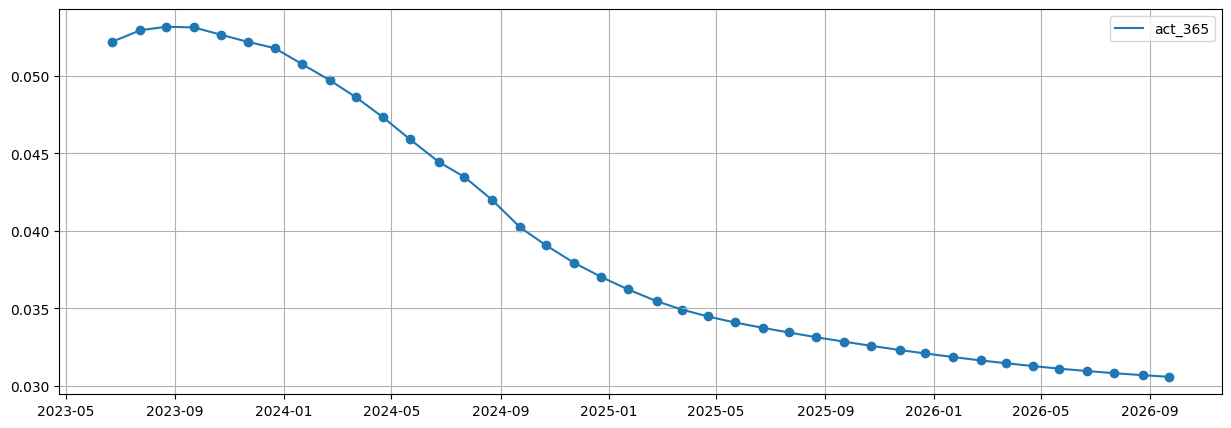

In [27]:
plt.figure(figsize = (15,5))
plt.grid()
plt.plot(discount_curve['Date'], discount_curve['3 Month Term SOFR Forward Curve'], label='act_365')
# plt.plot(discount_curve['Date'], discount_curve['3 Month Term SOFR Forward Curve'] / 360, label='act_360')
plt.scatter(discount_curve['Date'], discount_curve['3 Month Term SOFR Forward Curve'])
# plt.scatter(discount_curve['Date'], discount_curve['3 Month Term SOFR Forward Curve'] / 360)
plt.legend()

In [39]:
Implied_Volatility = get_Implied_volatility(options_data, discount_curve)
# Implied_Volatility_without_extrapolation = computing_SVI_IV(Implied_Volatility, ticker, low_limit = 0.1, high_limit = 2.5, N = 1000, extrapolation=False)

0.9994341913047694
0.9984408117387334
0.9974433671042356
0.996441887667301
0.9954364037191361
0.9944365817209252
0.9914413361365109
0.9875015884797994
0.982763718965464
0.9790865582864342
0.9754750316586295
0.9713921860595224
0.9654801798054518
0.9574147134388308
0.9520673233325128
0.9473317761220473
0.9458411121944916
0.9367683515497632
0.9257379302549292


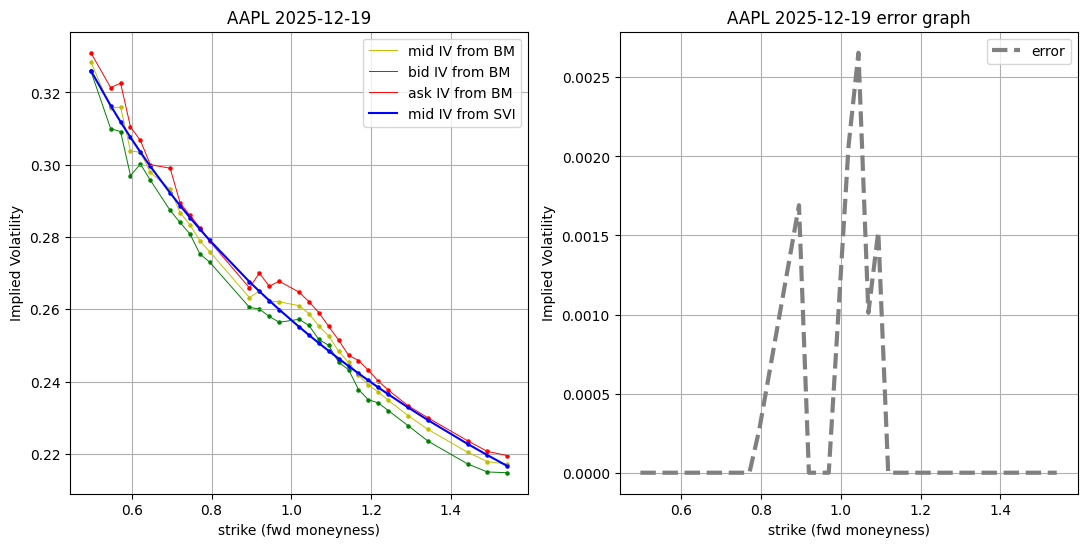

In [19]:
lines_2D_SVI(ticker, Implied_Volatility_without_extrapolation, 18)

In [7]:
value_options = get_data_about_option(Implied_Volatility_without_extrapolation, options_data, optionTypes=None)

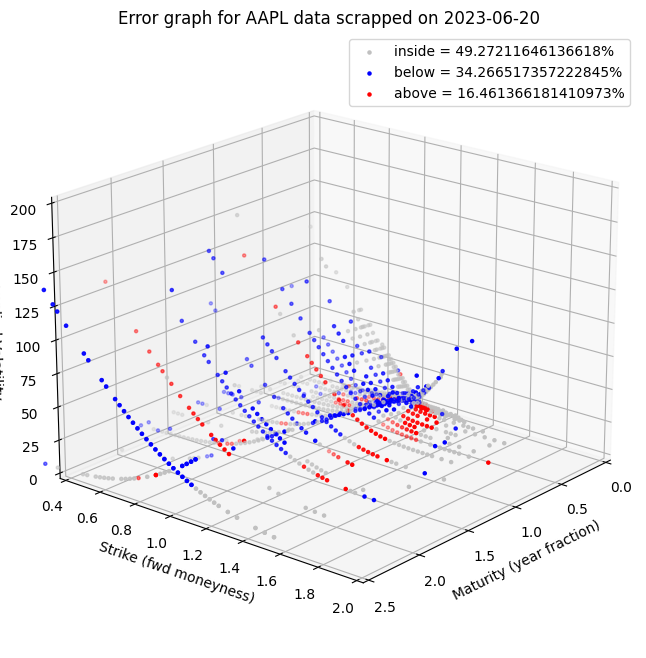

In [9]:
data_date = '2023-06-20'
error_graph_3D(value_options, ticker, data_date, type_option=None)

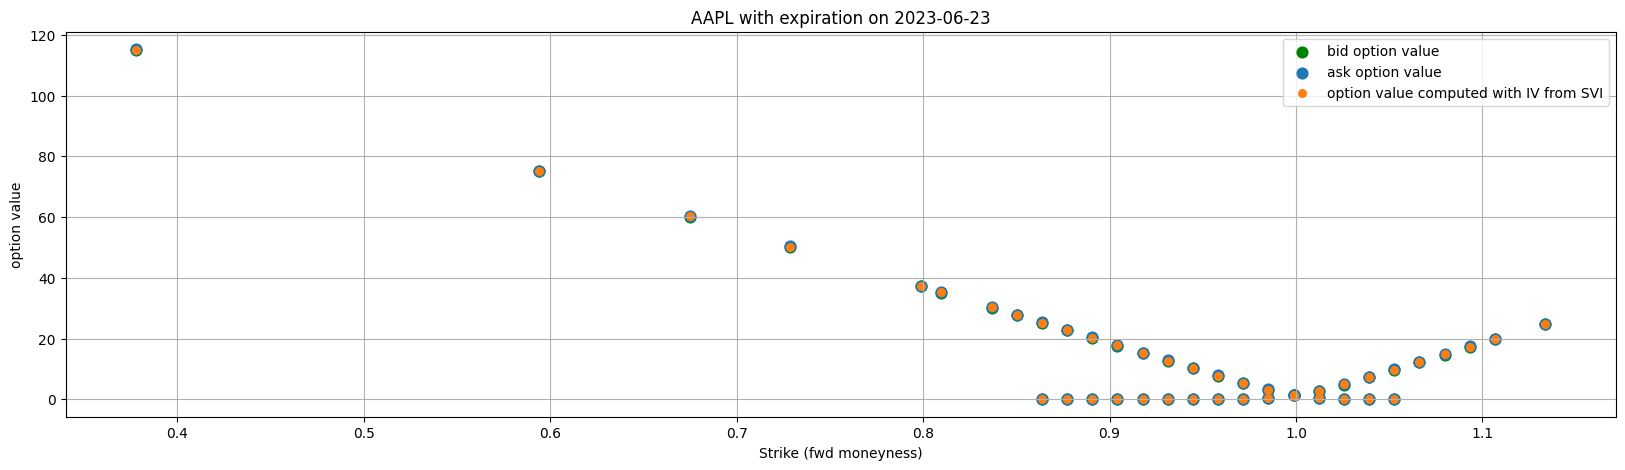

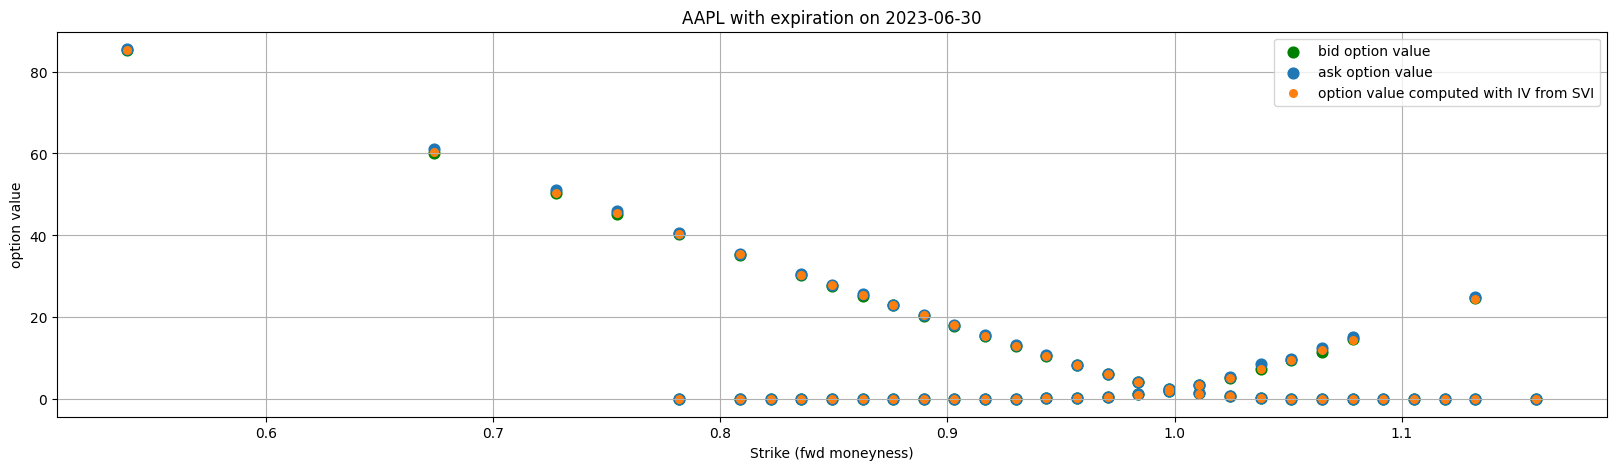

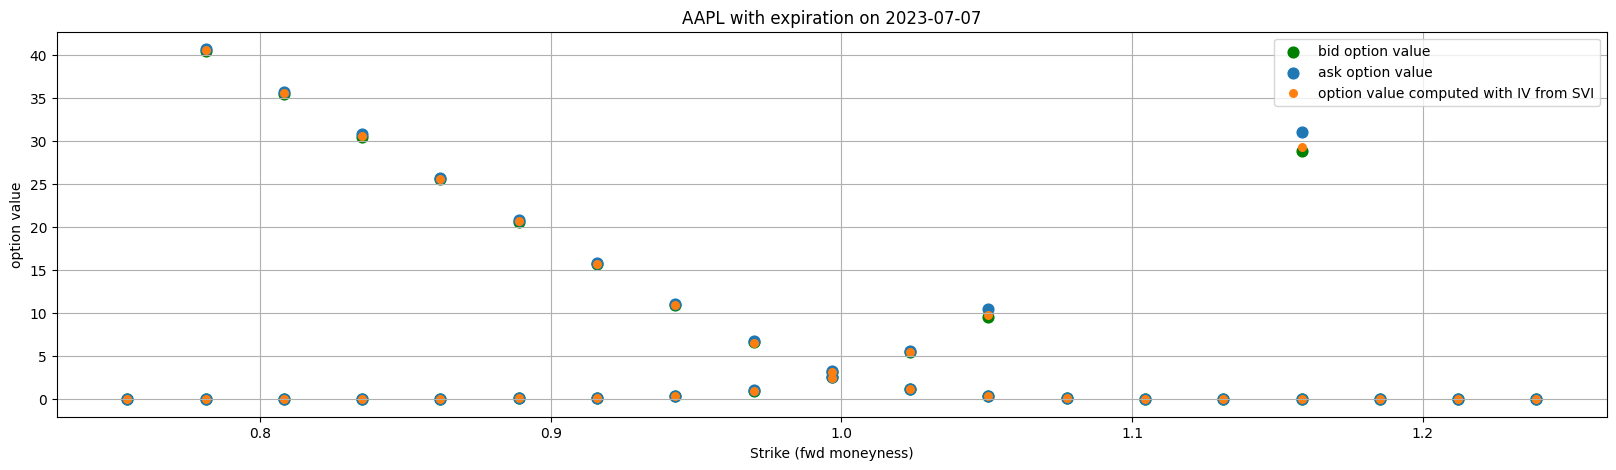

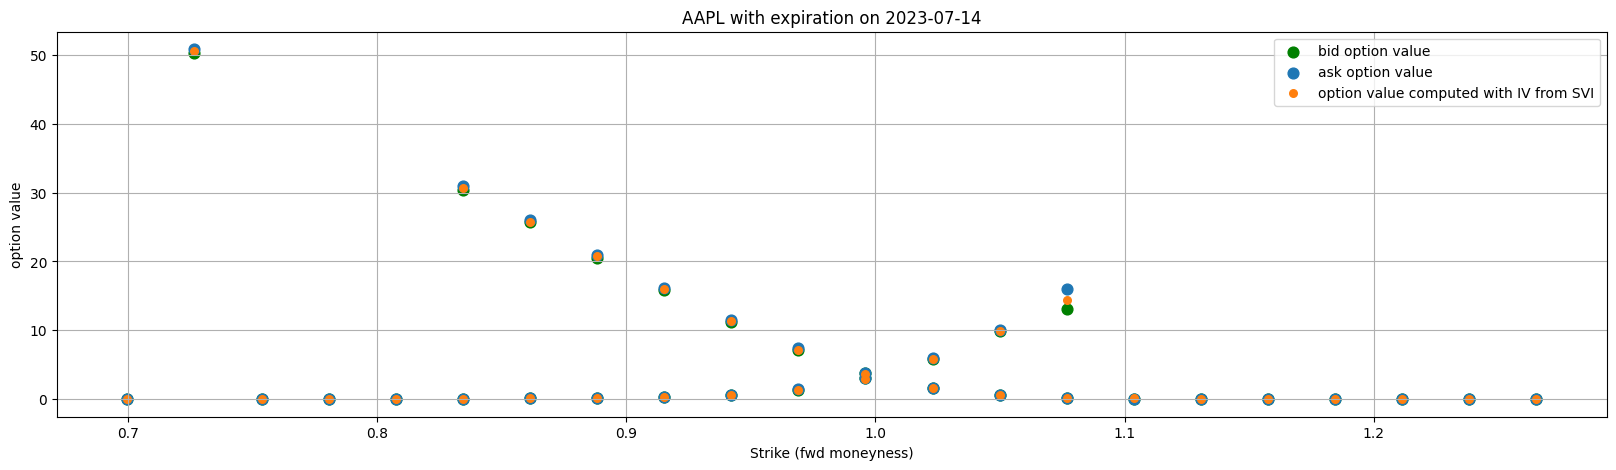

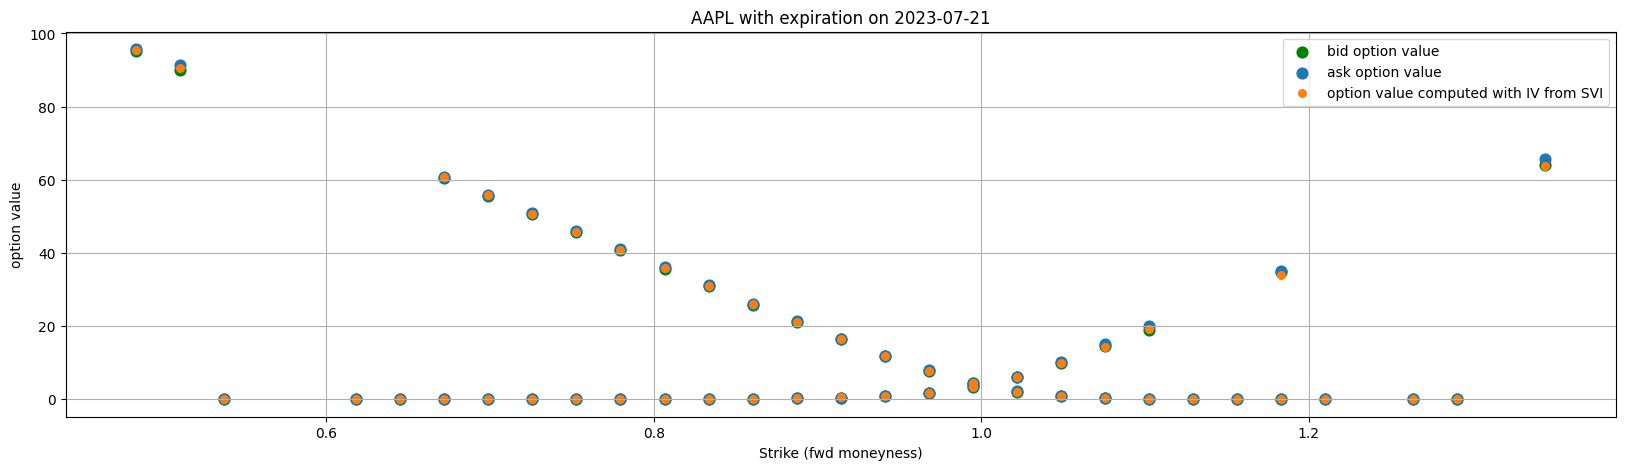

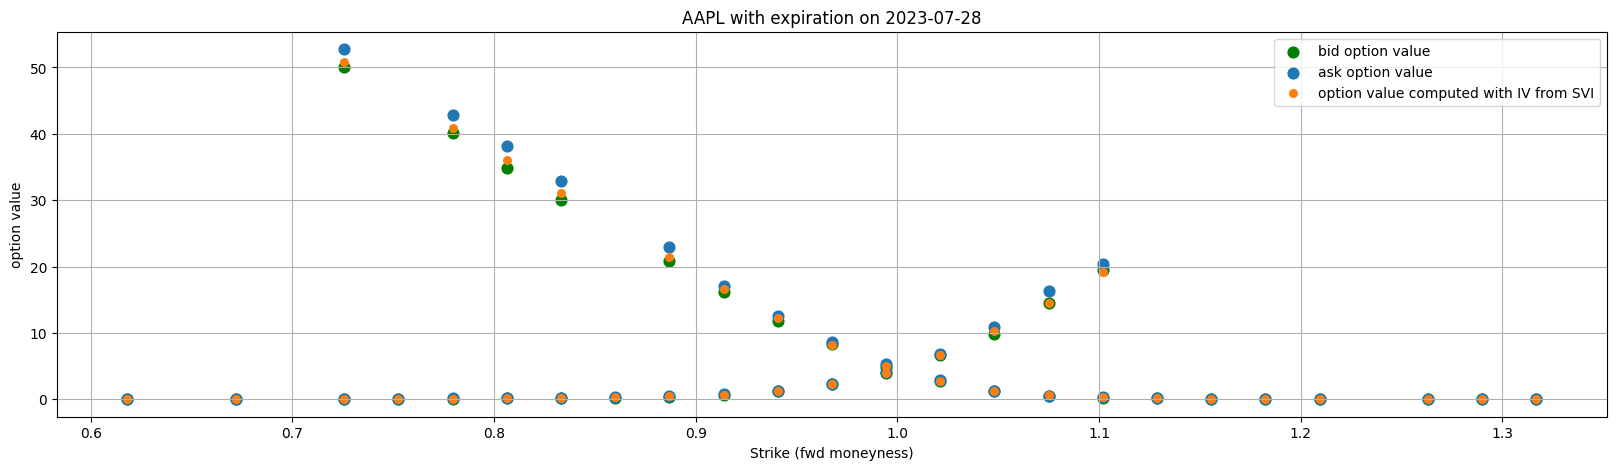

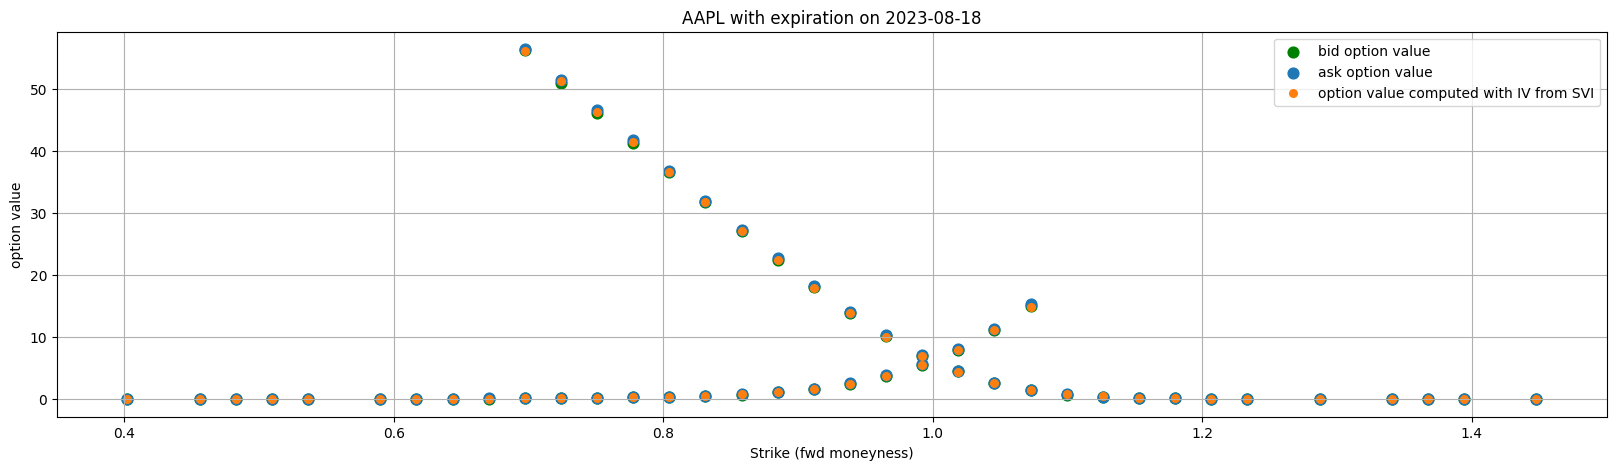

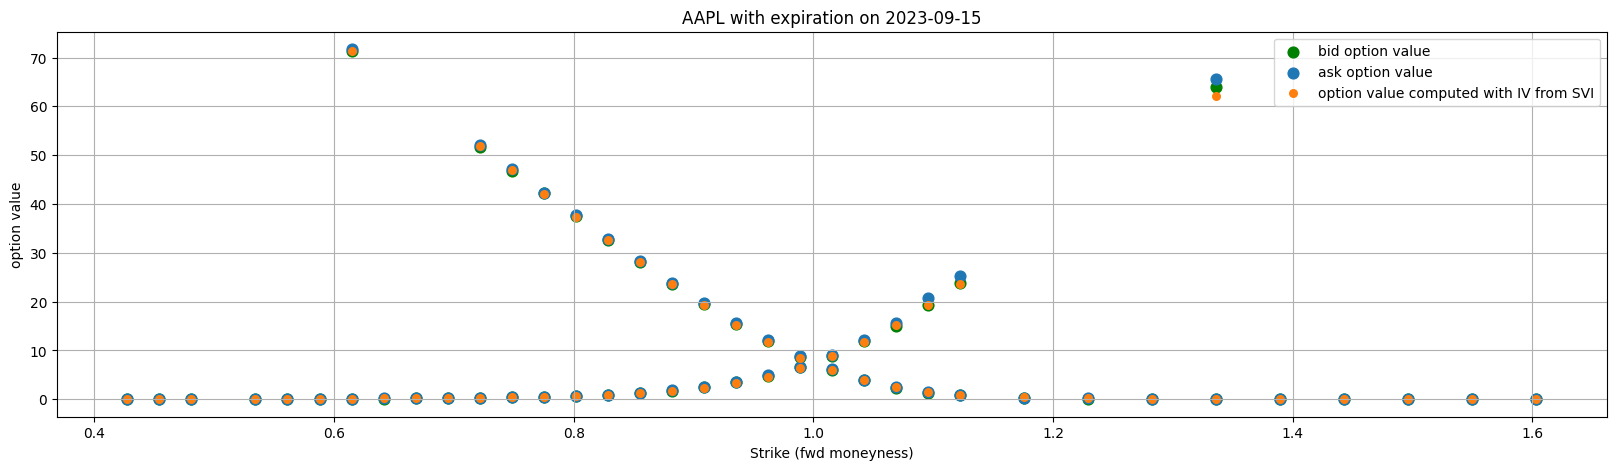

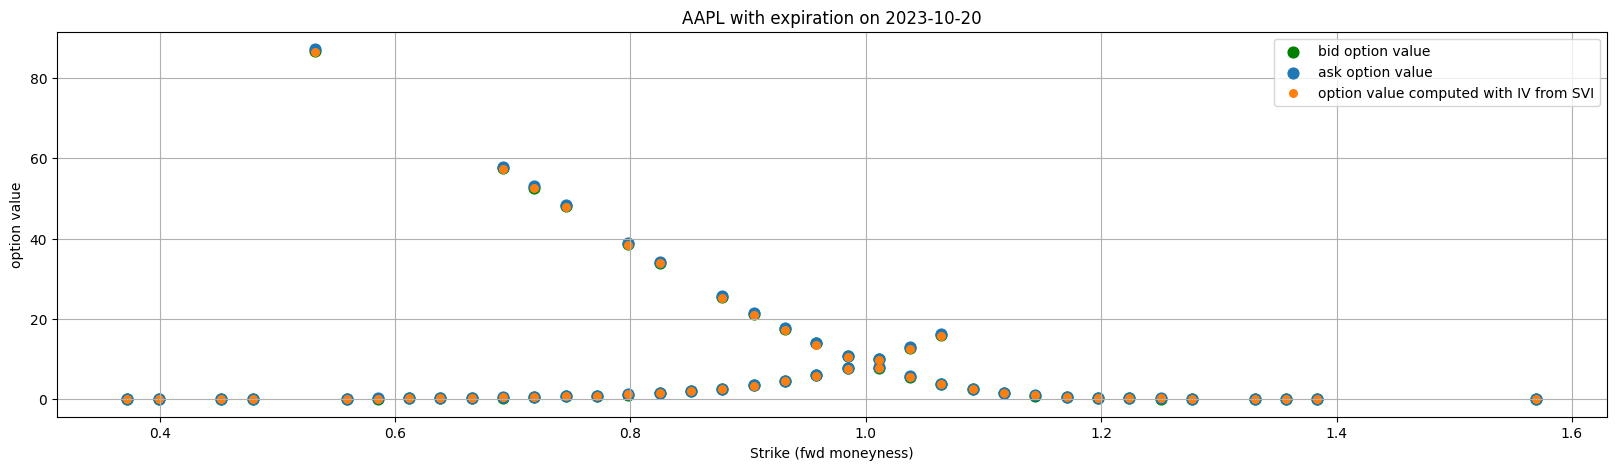

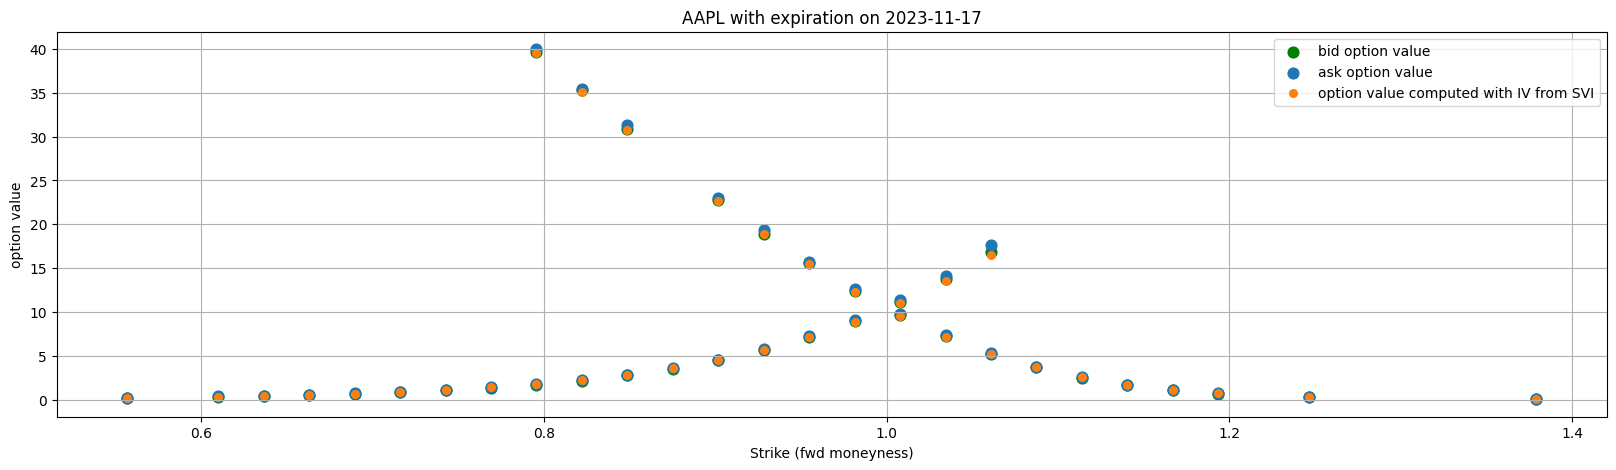

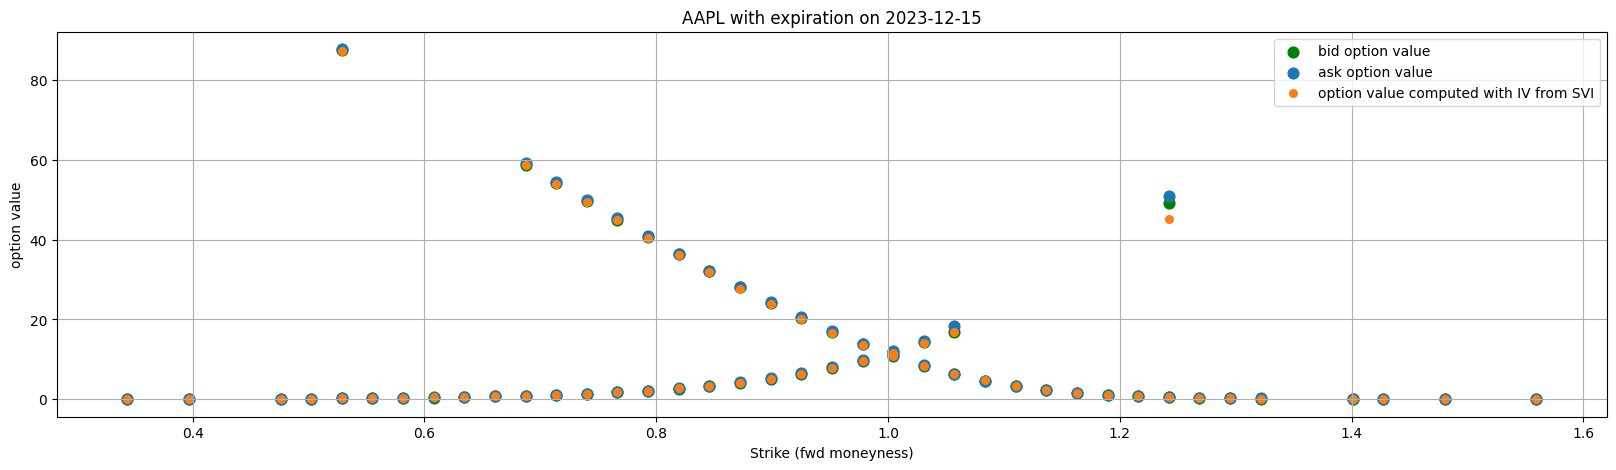

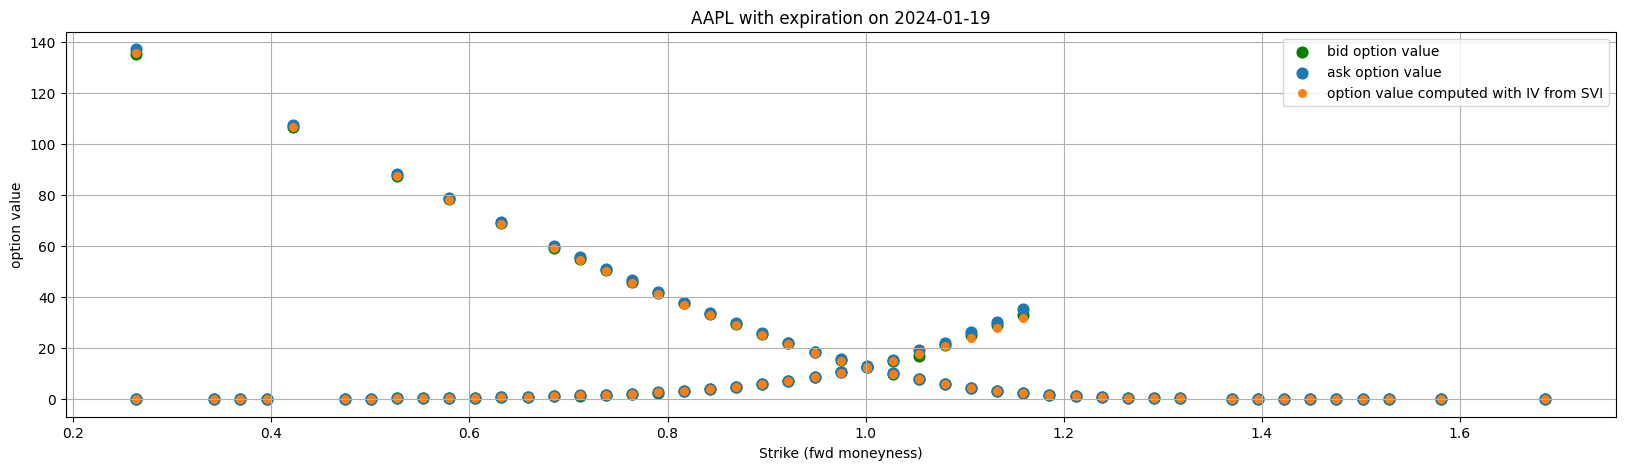

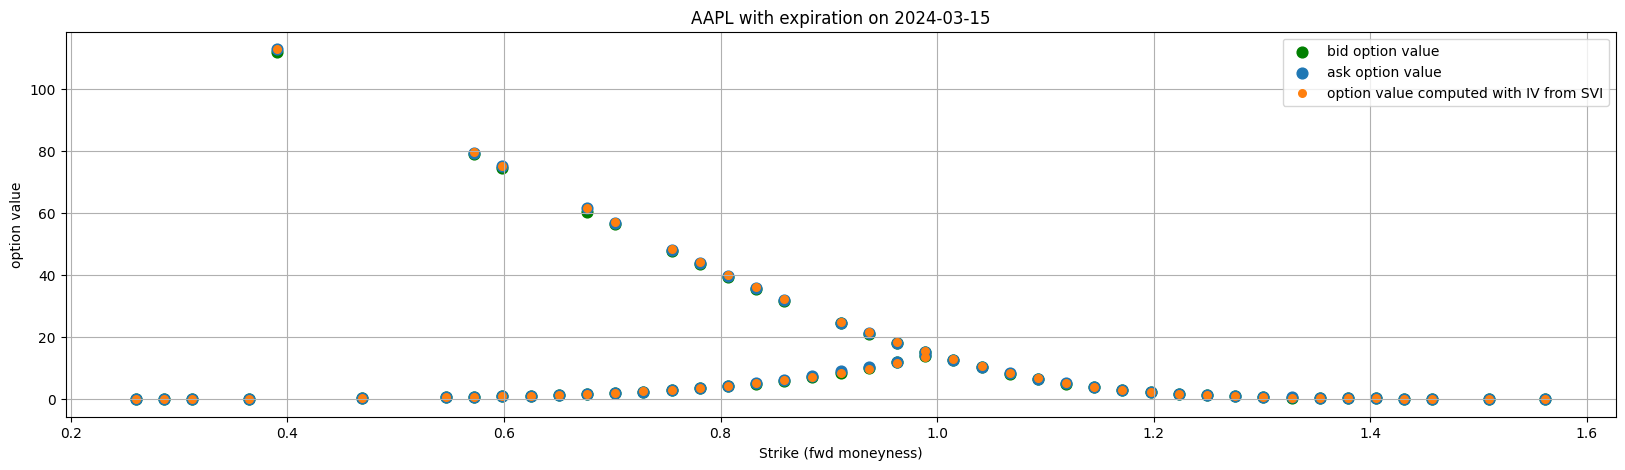

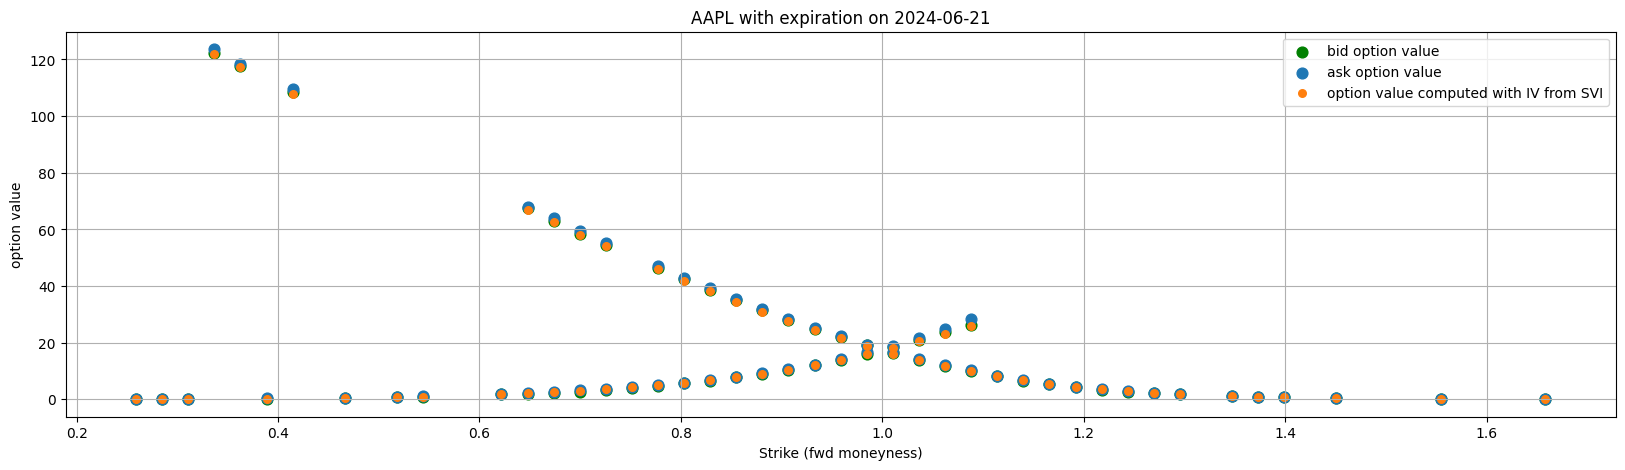

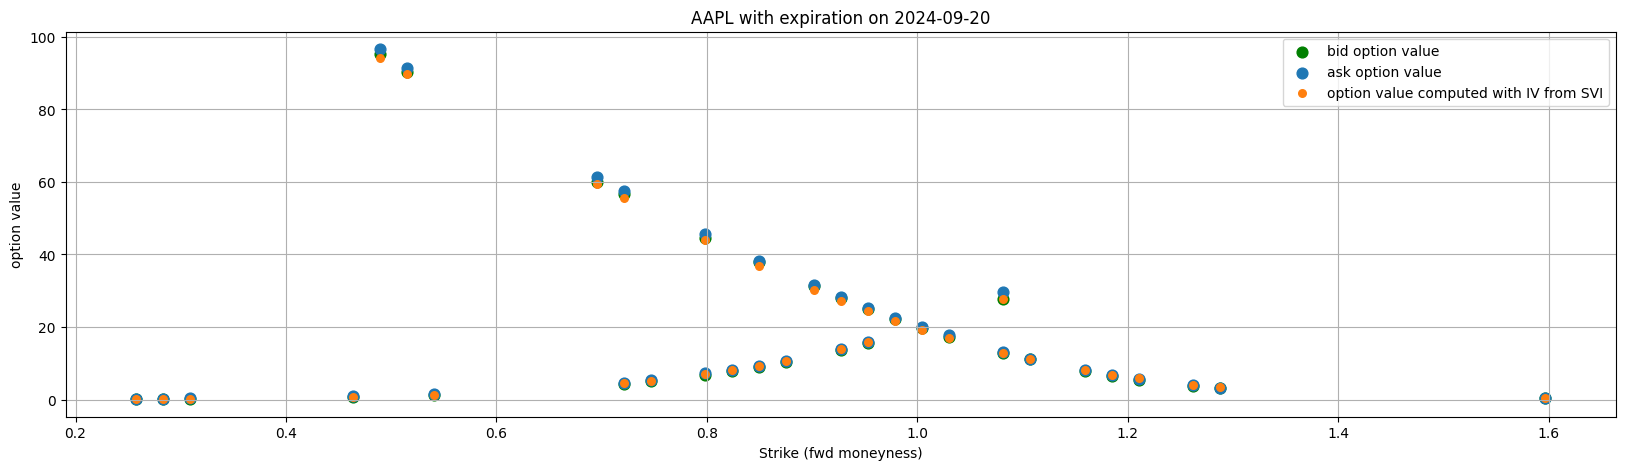

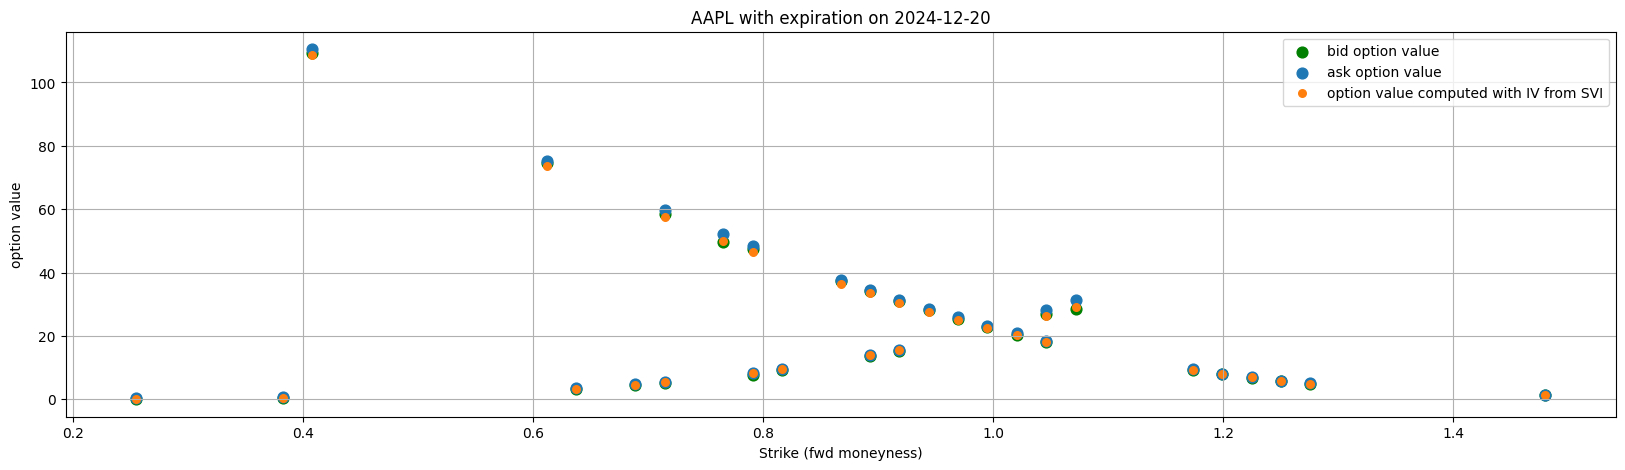

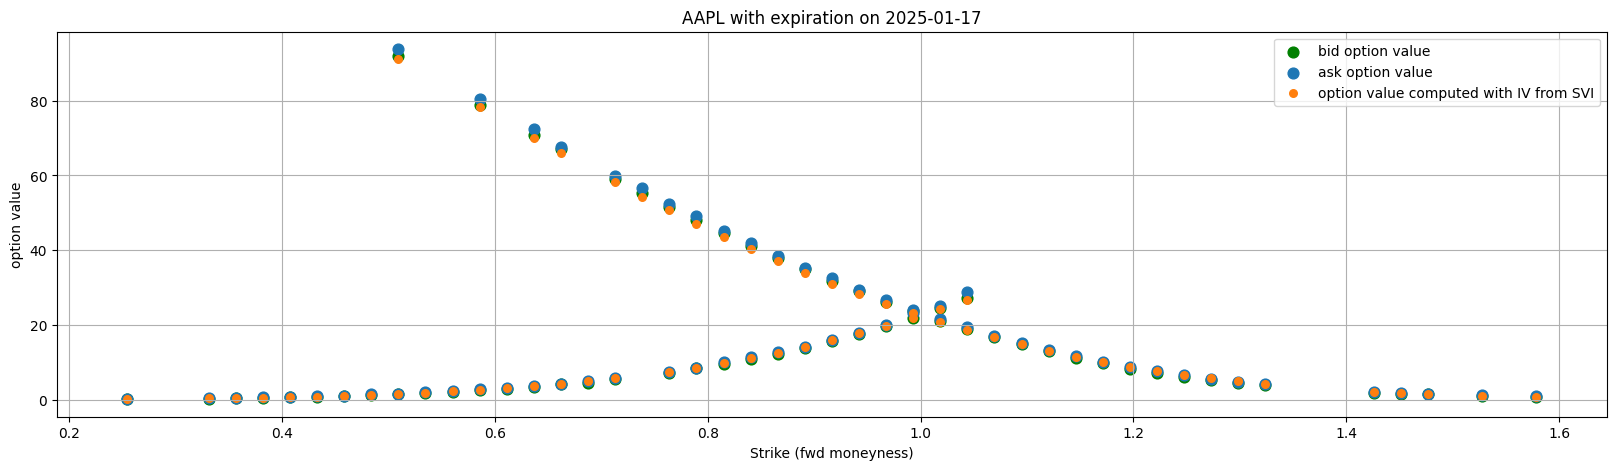

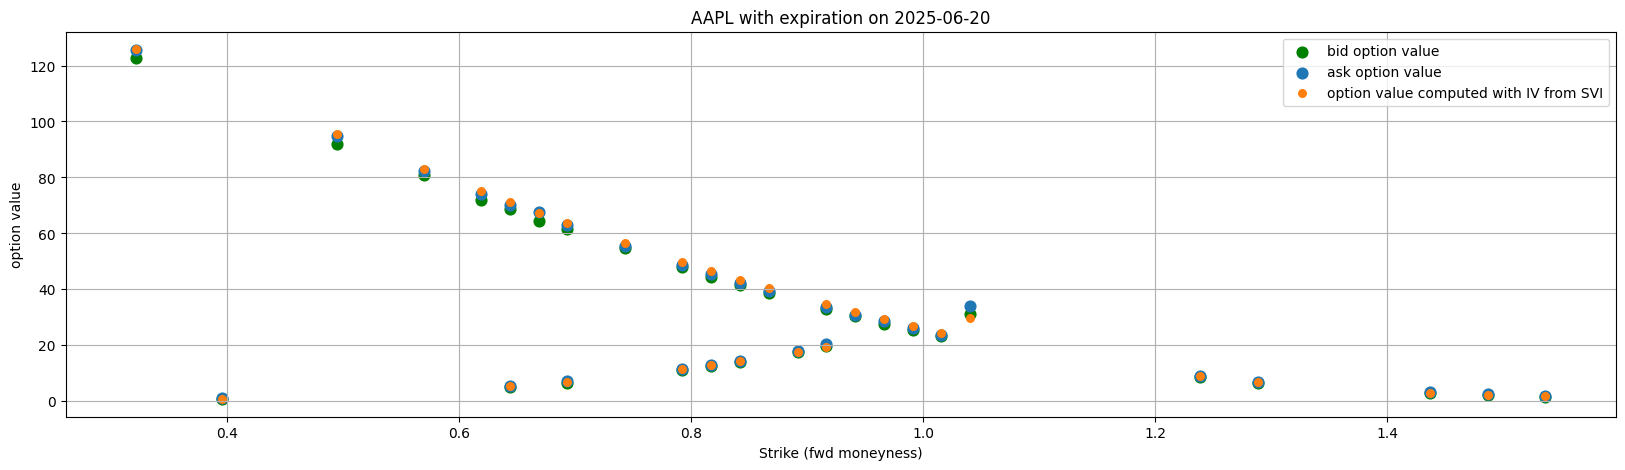

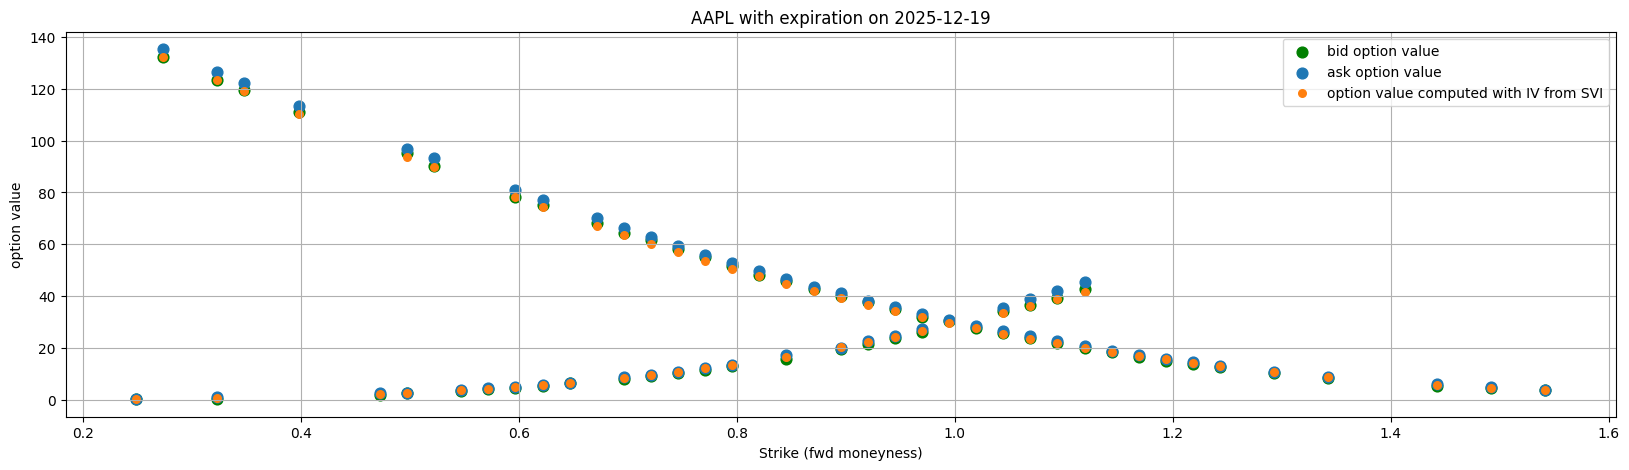

In [20]:
expiry_date_list= options_data["expiryDate"].unique()
for expiry_date in expiry_date_list:
    a = value_options.loc[(value_options['expiry_date'] == expiry_date)] #& (value_options['x_grid'] > 1) & (value_options['optionType'] == 'puts')]
    plt.figure(figsize = (20,5))
#     plt.scatter(a['x_grid'], a['value_option'], label='option value computed with IV from SVI', s=100.)
    plt.scatter(a['x_grid'], a['bid'], label='bid option value', s=60., color='g')
    plt.scatter(a['x_grid'], a['ask'], label='ask option value', s=60.)
    plt.scatter(a['x_grid'], a['value_option'], label='option value computed with IV from SVI', s=30.)
    plt.title(ticker + ' with expiration on ' + expiry_date)
    plt.ylabel(r'option value')
    plt.xlabel(r'Strike (fwd moneyness)')
    plt.grid()
    plt.legend()
    plt.show()

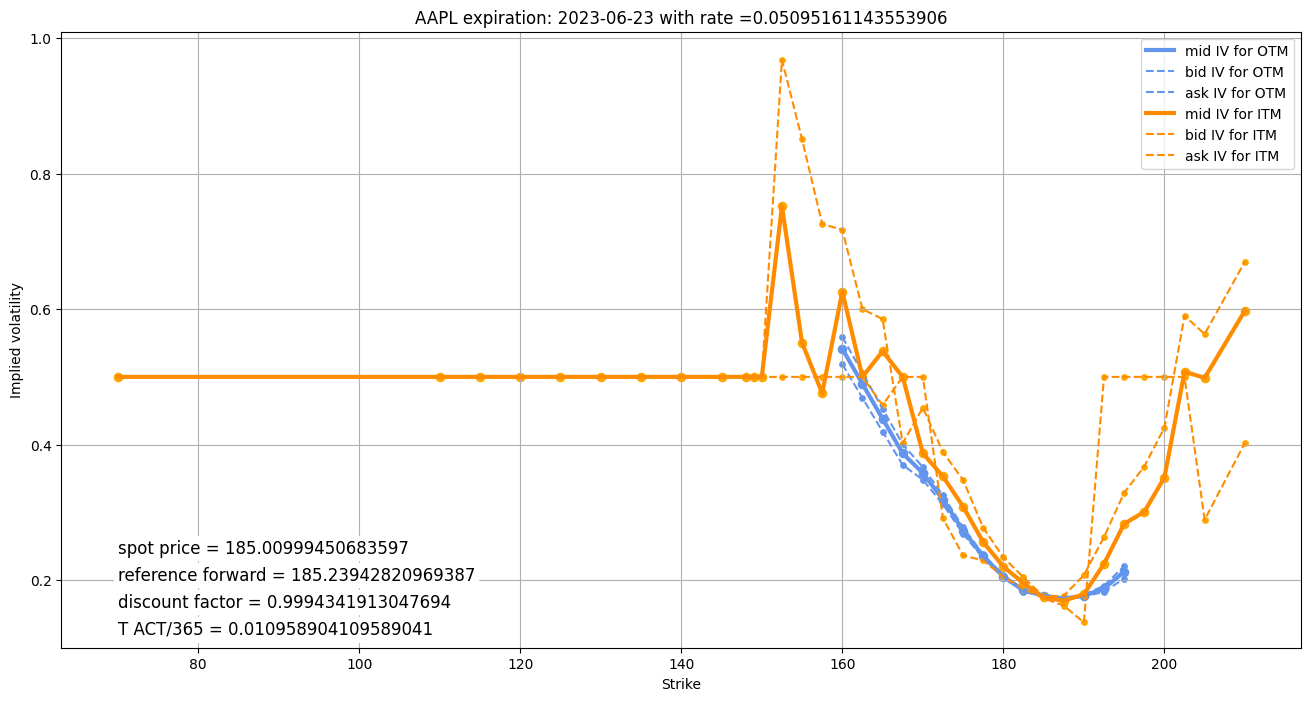

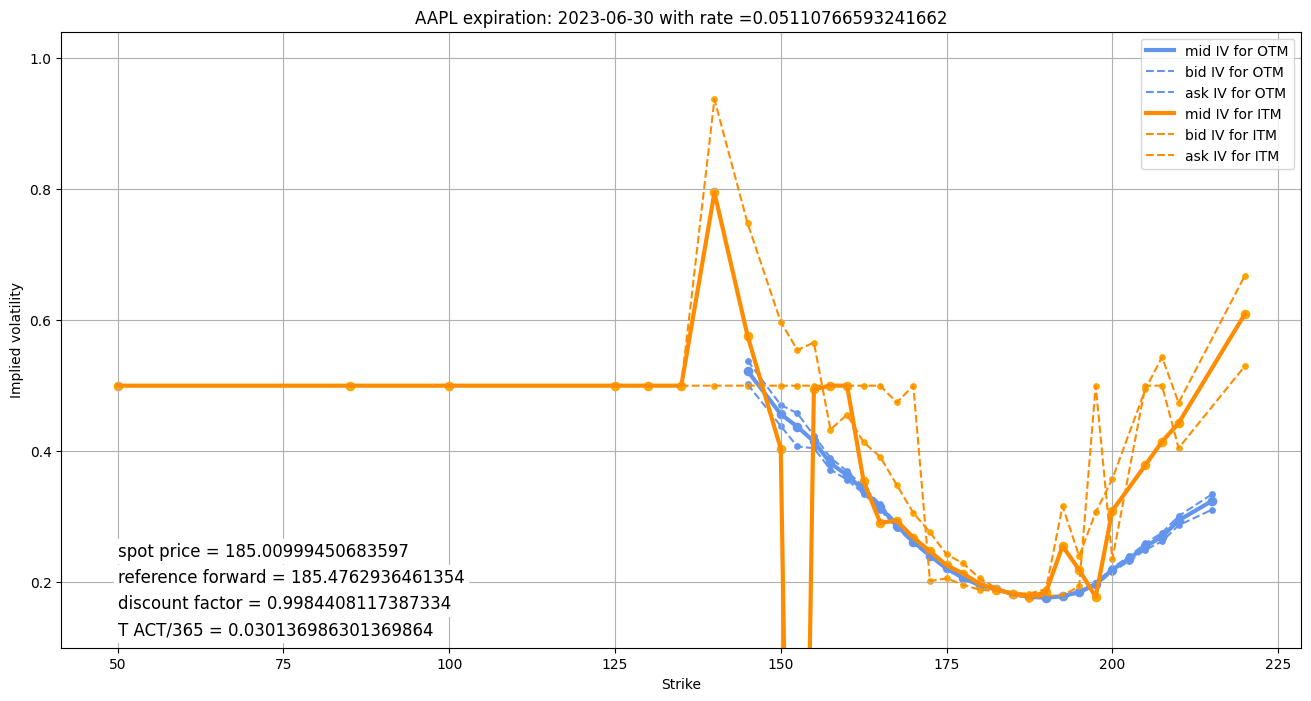

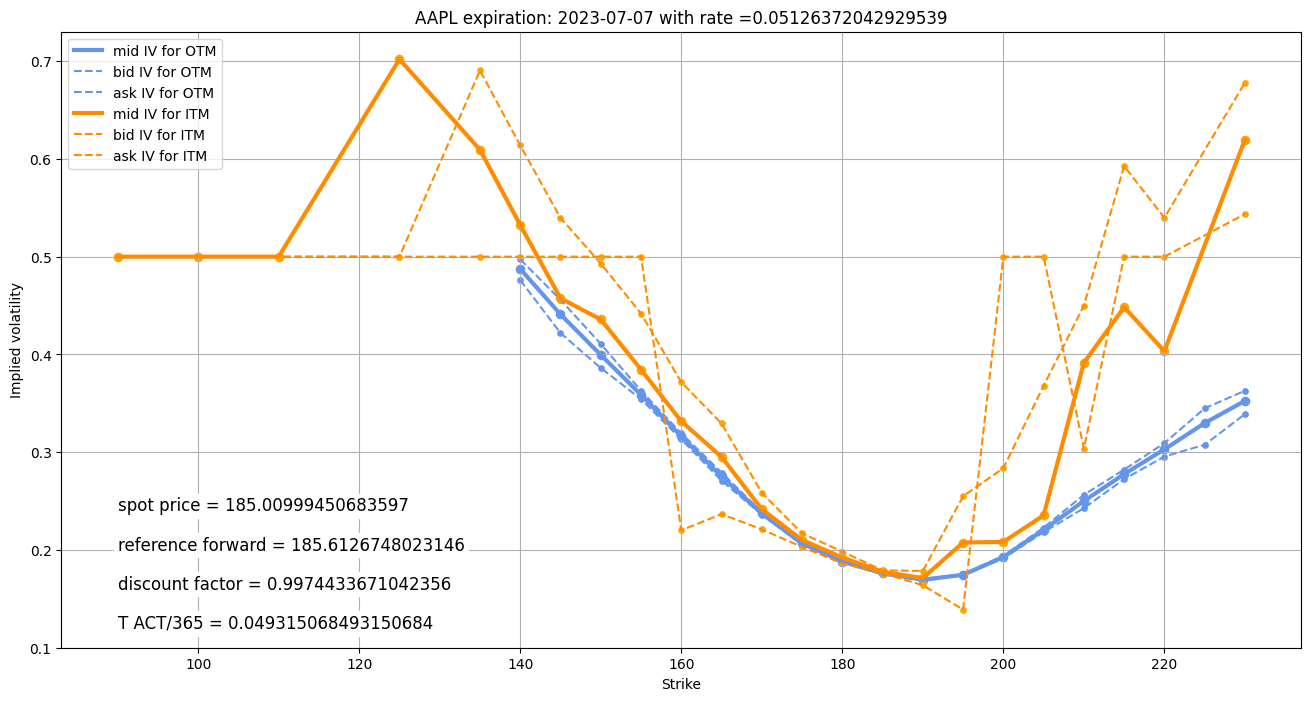

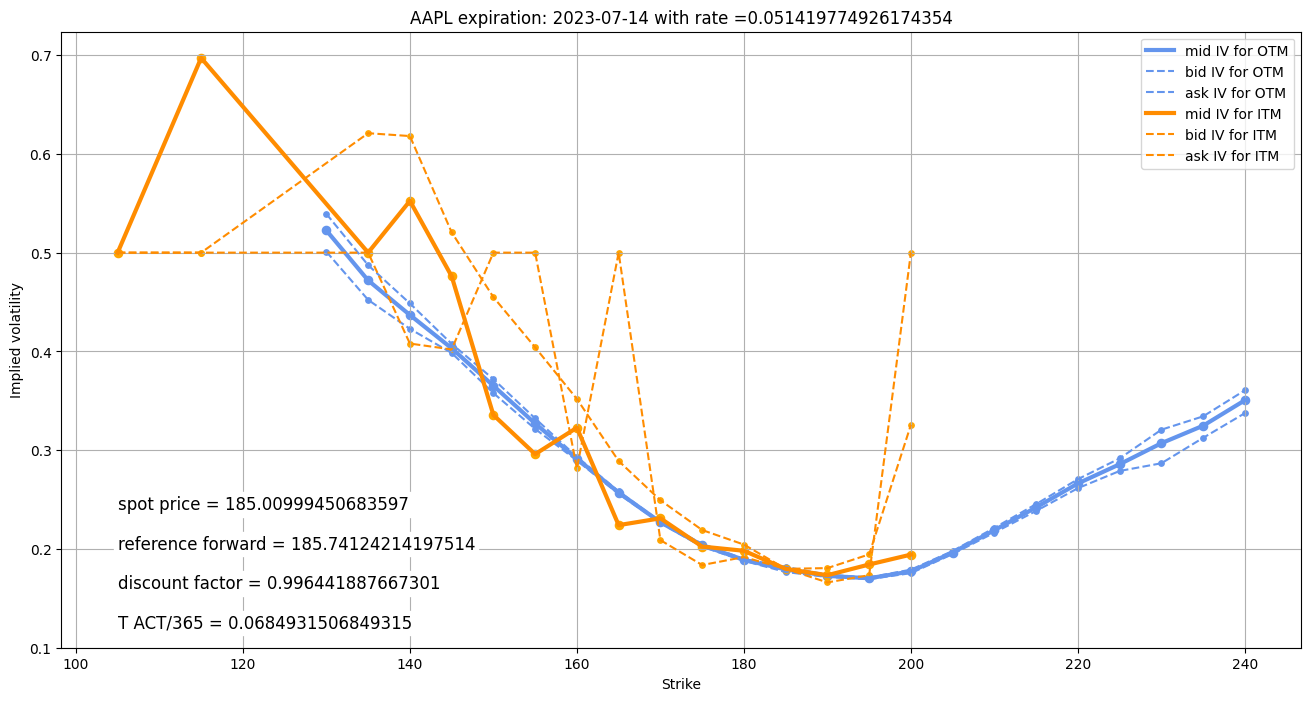

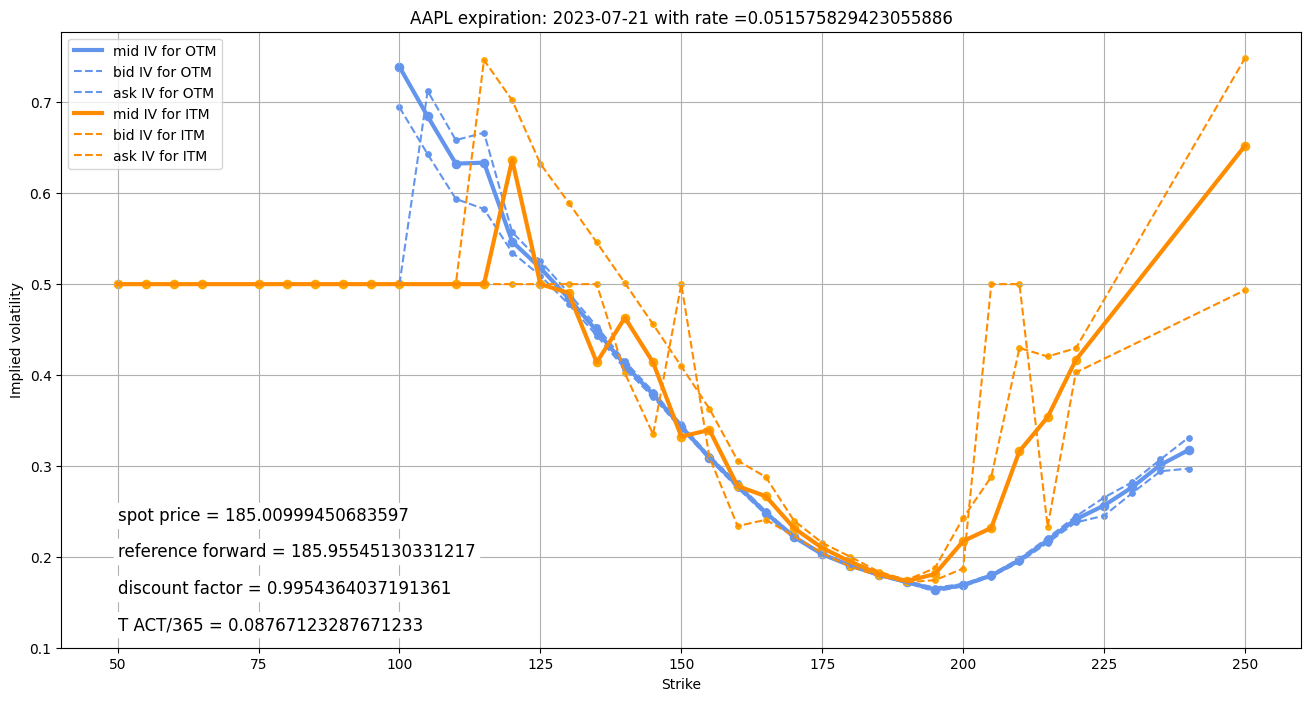

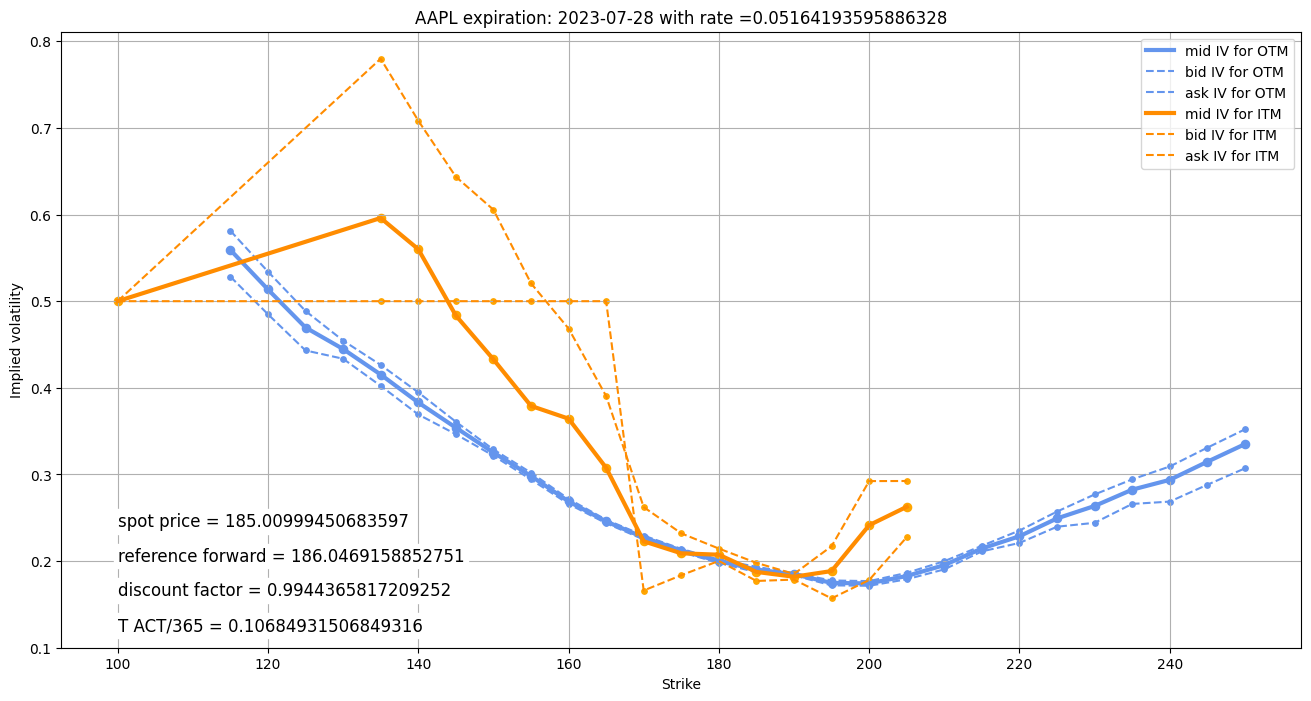

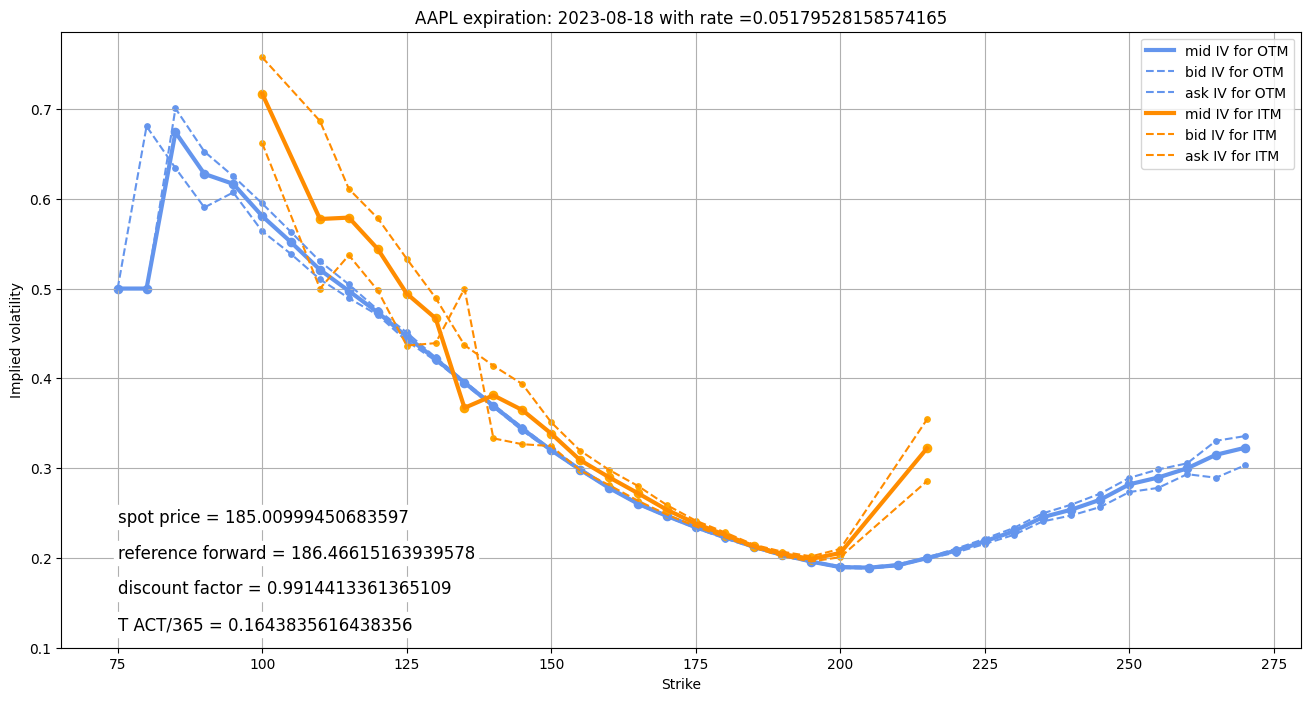

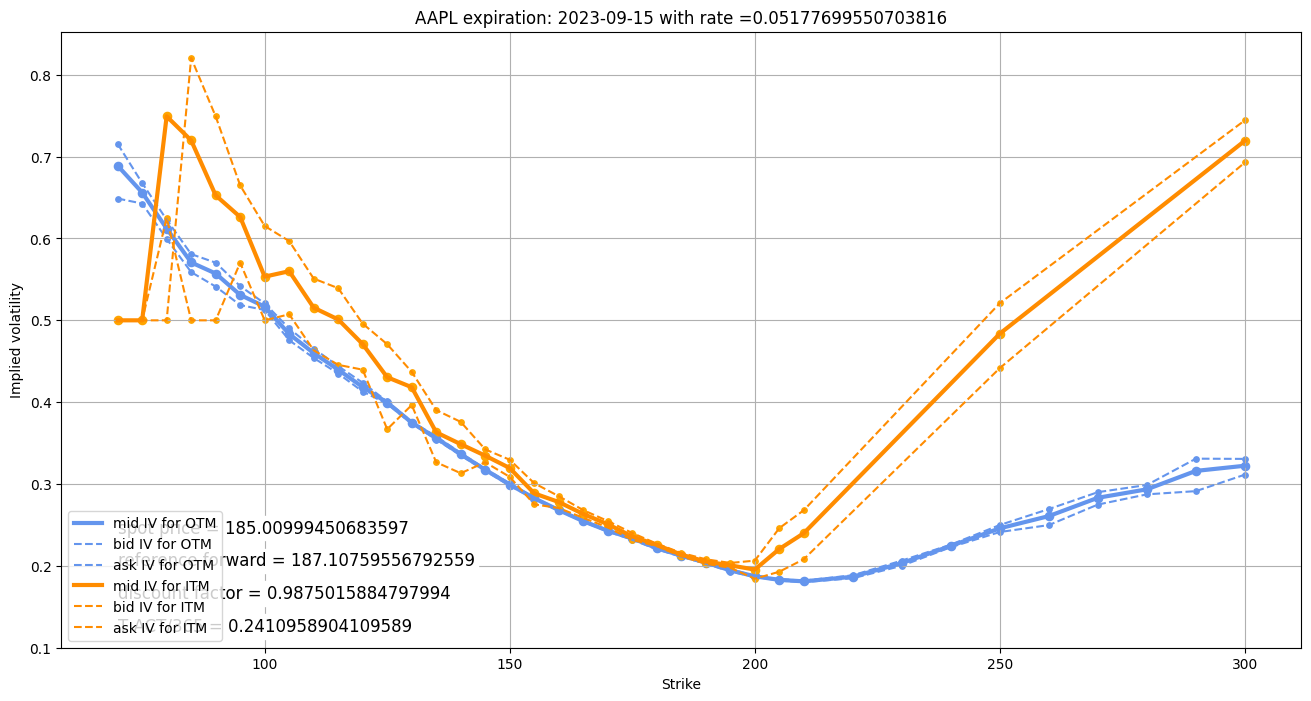

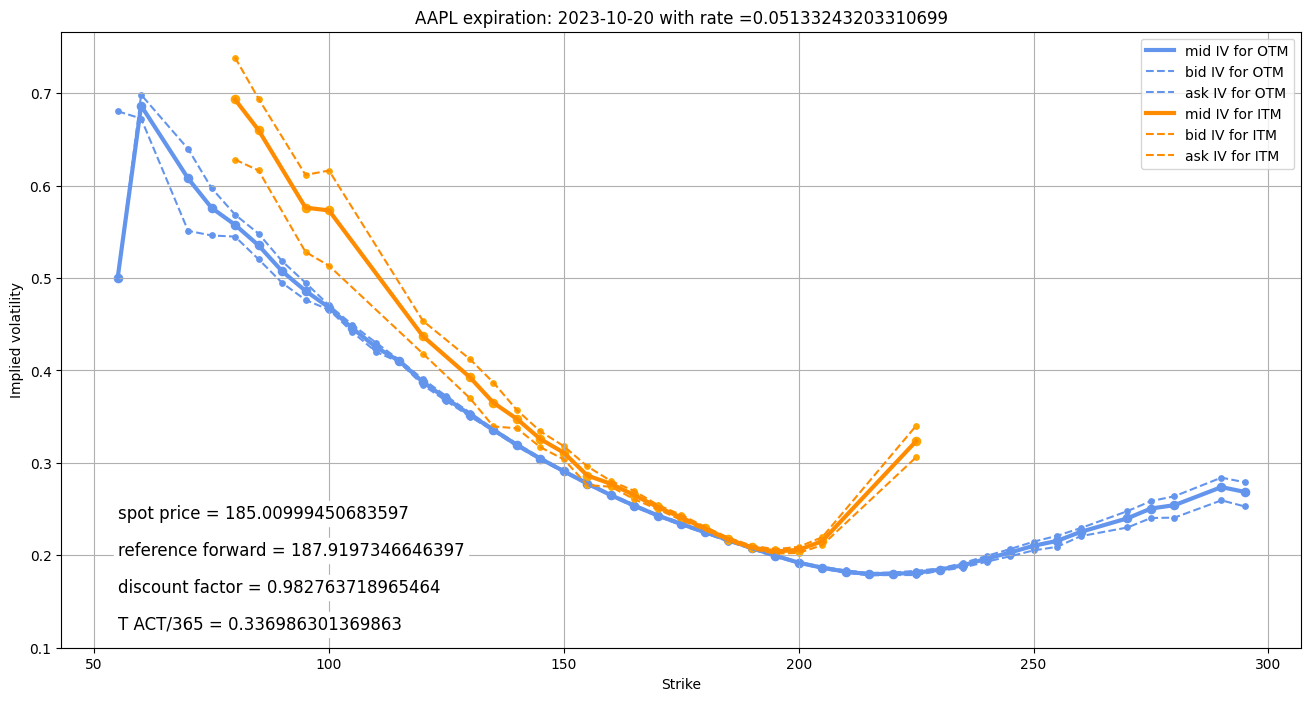

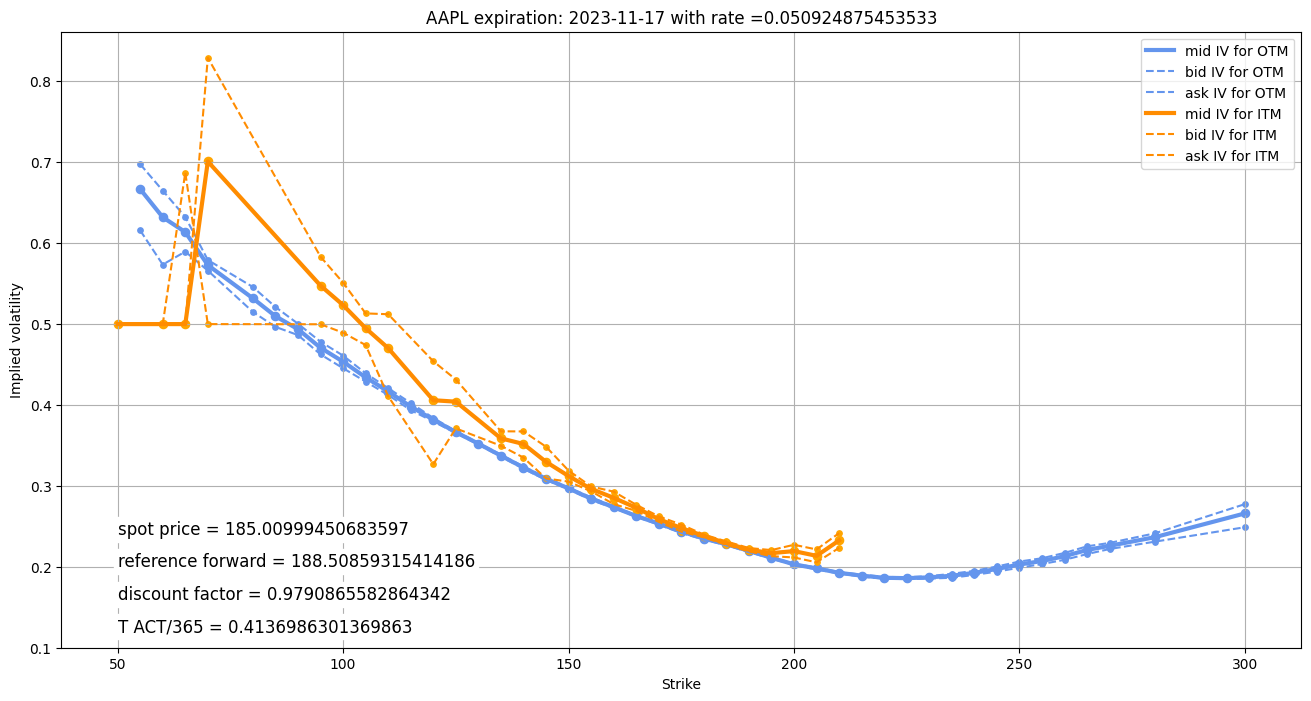

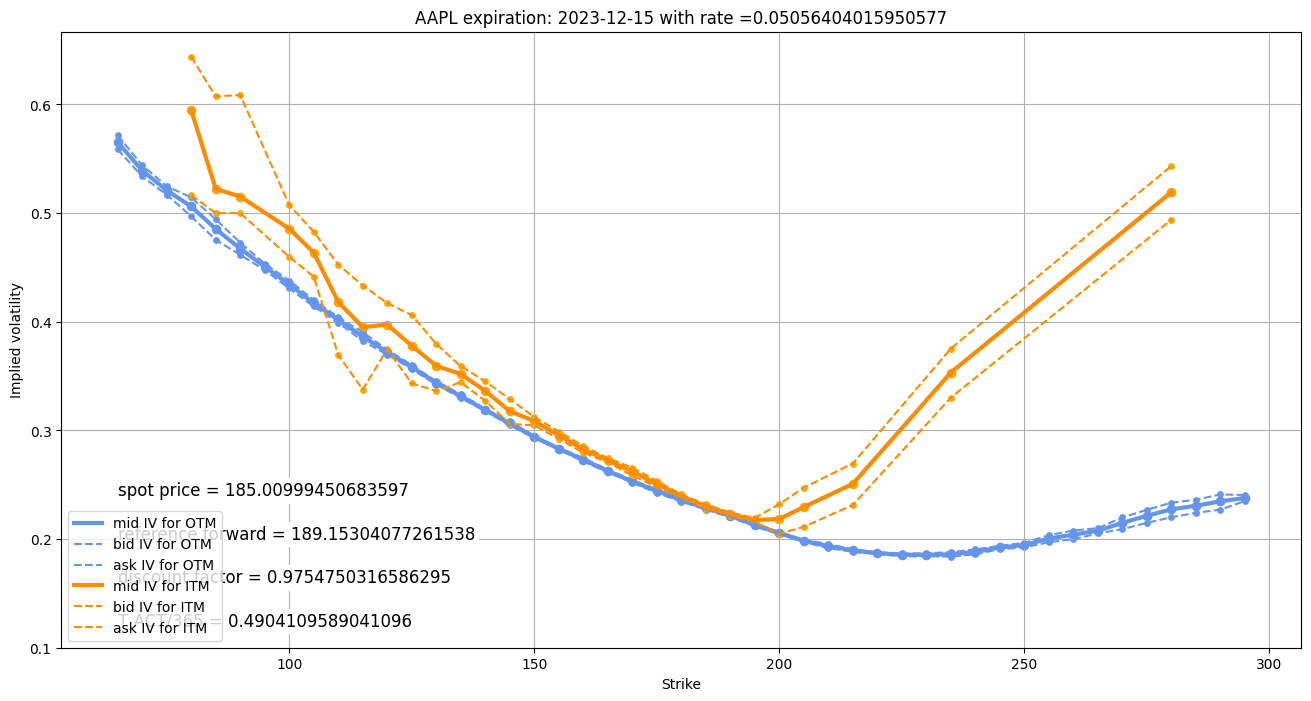

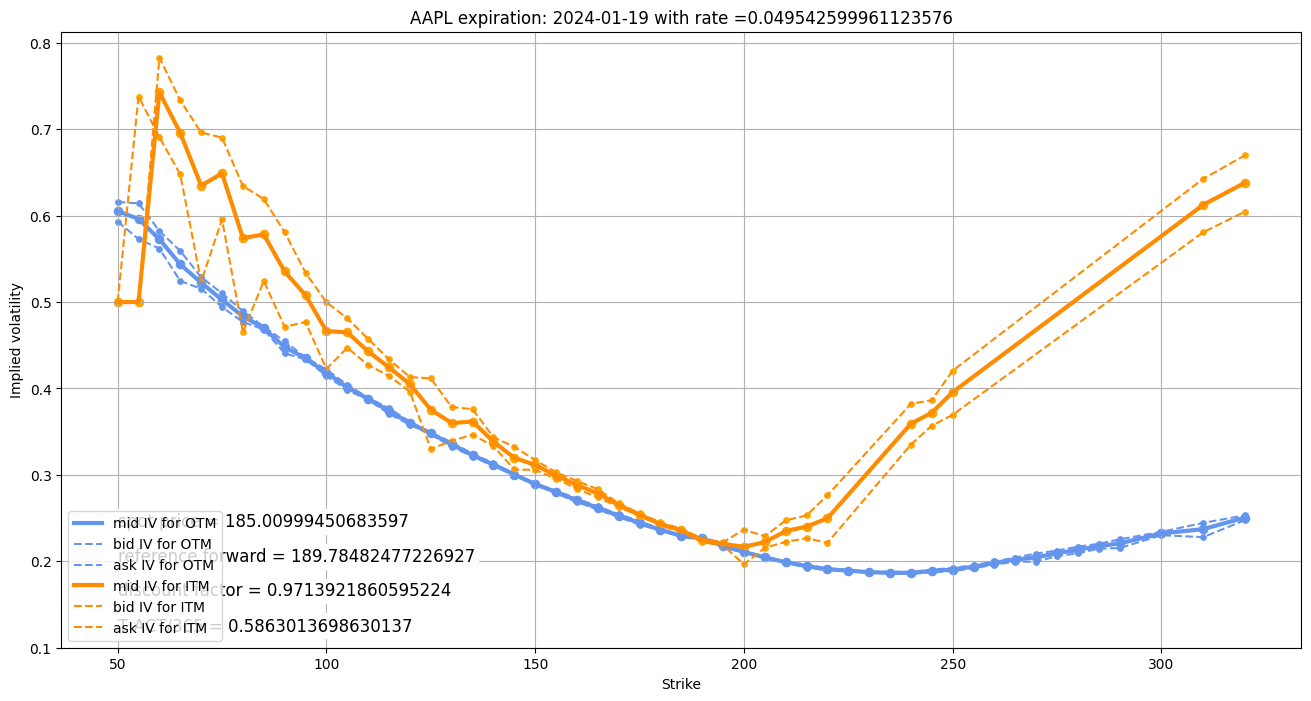

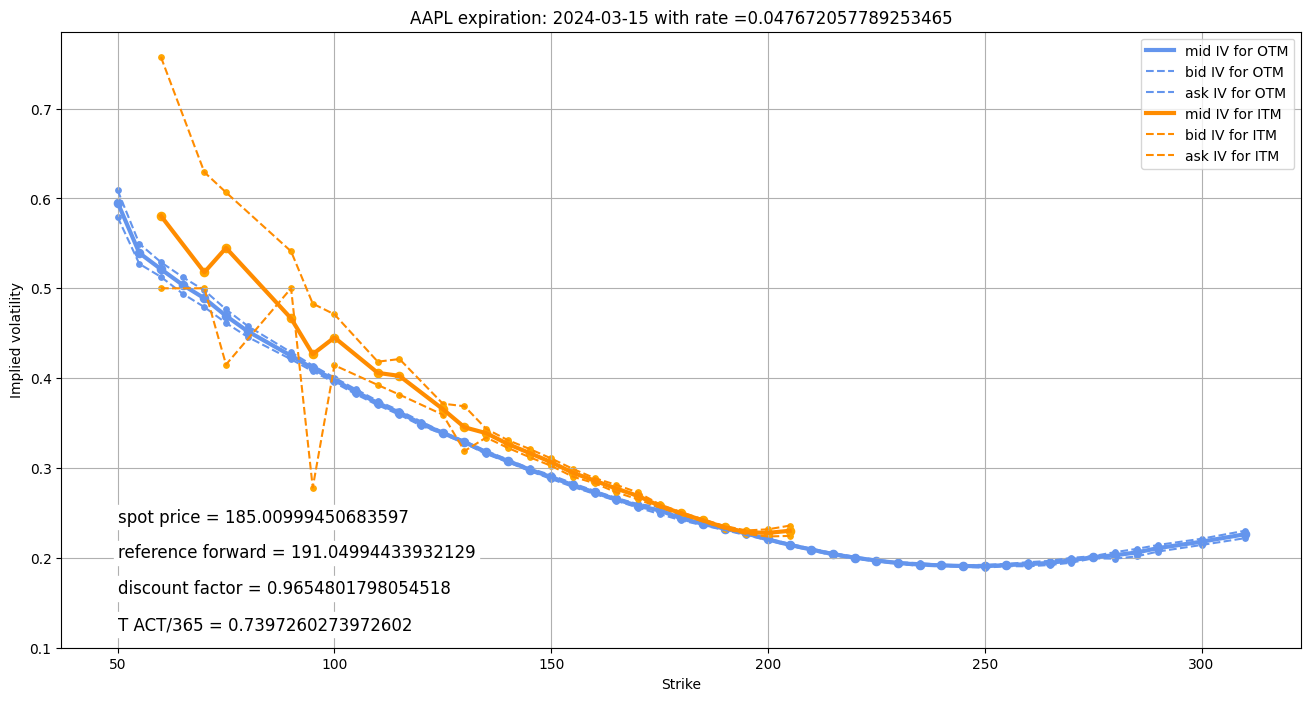

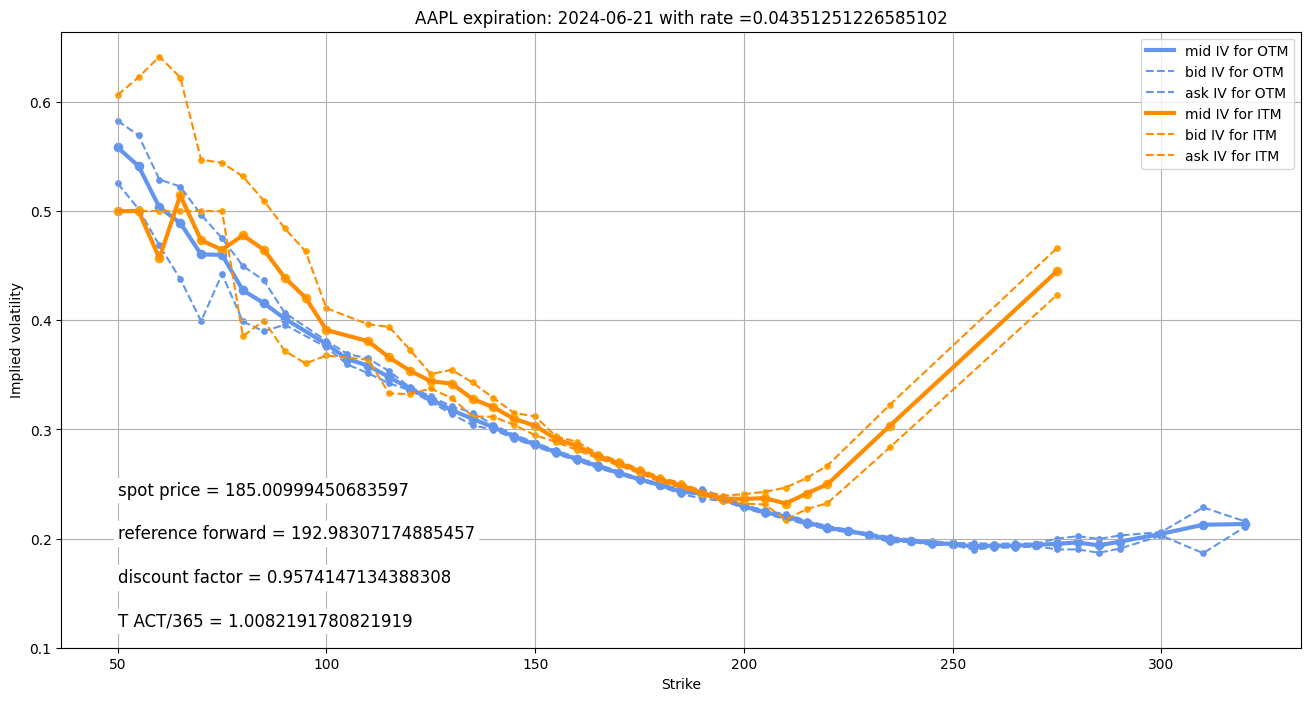

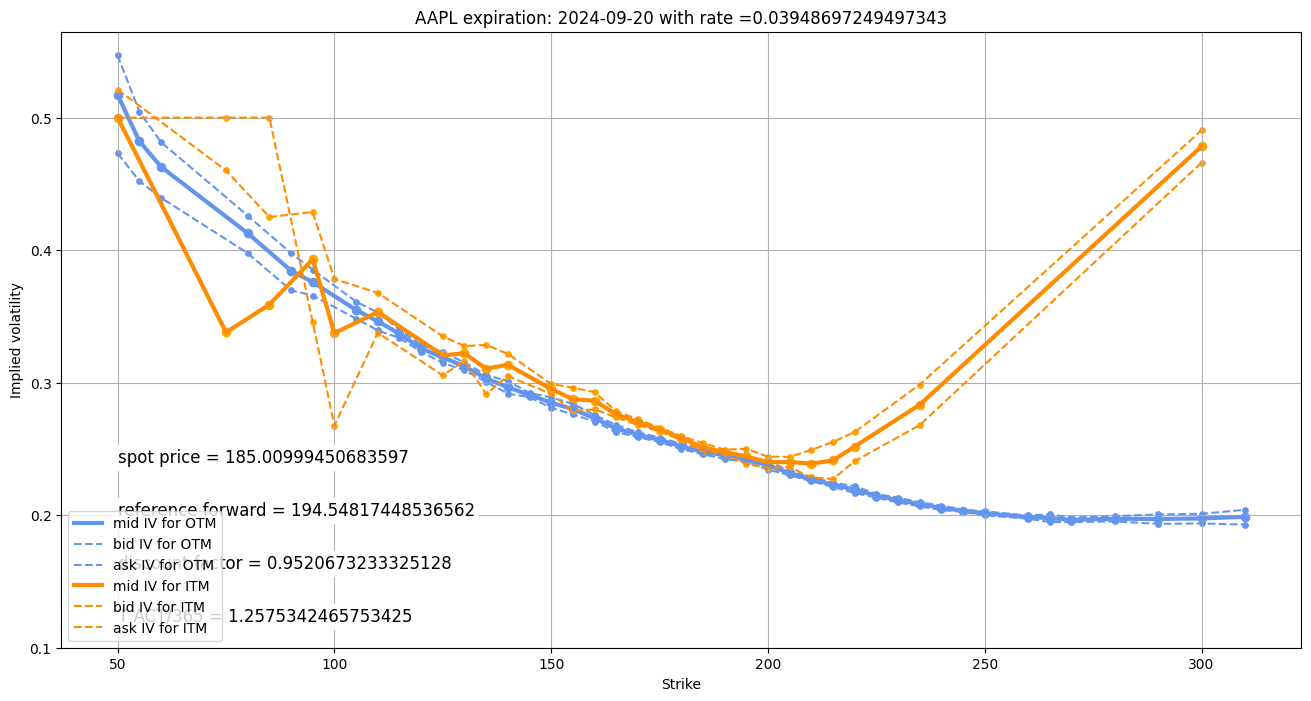

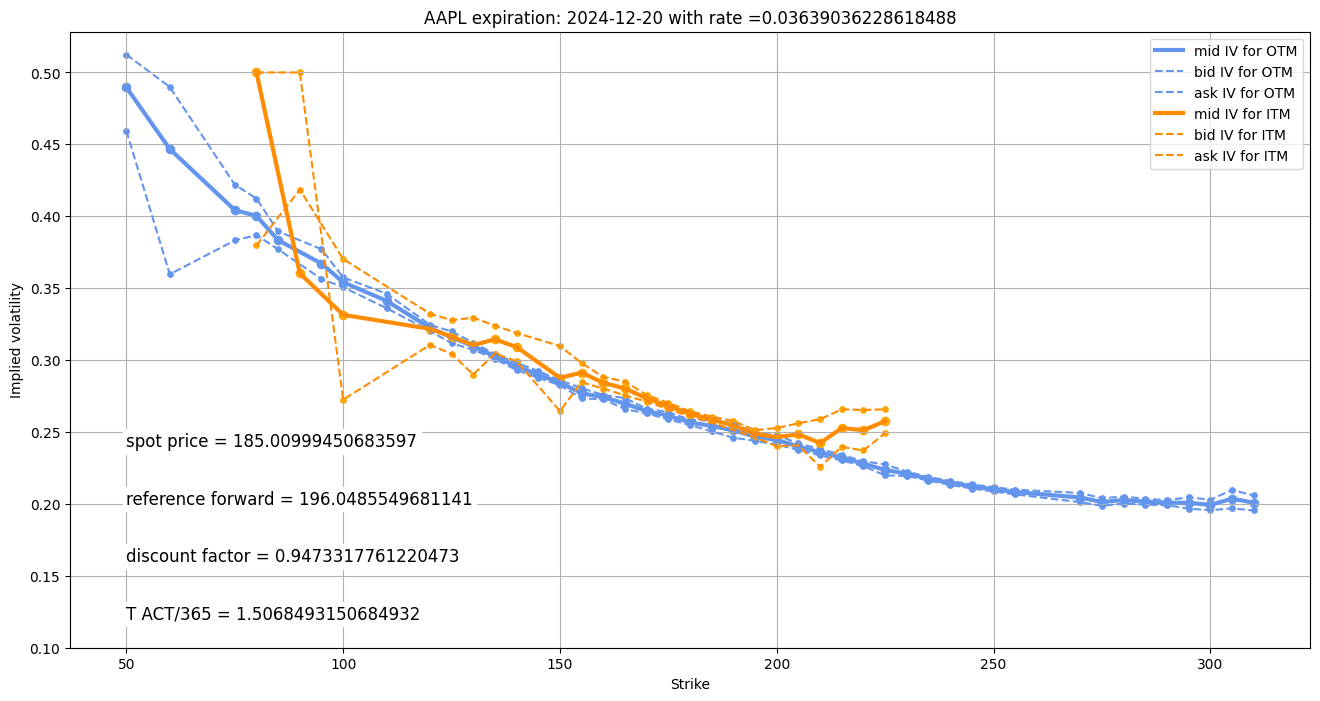

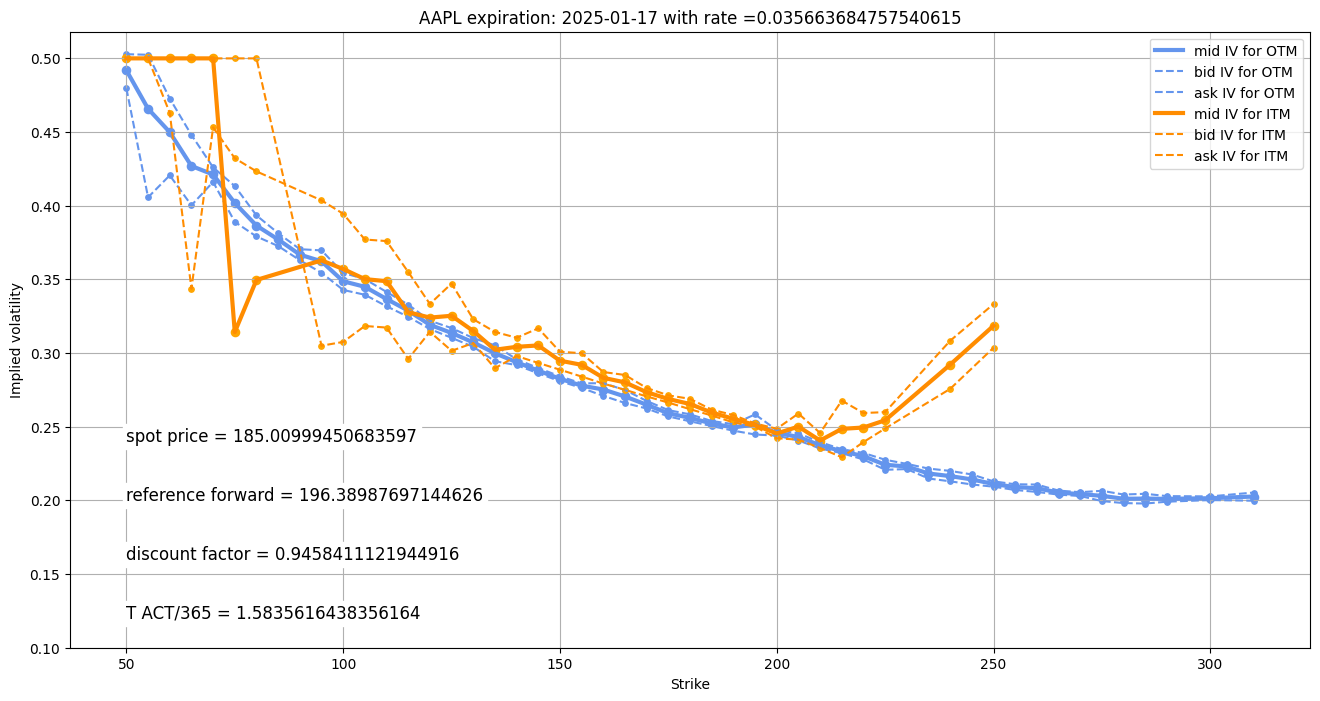

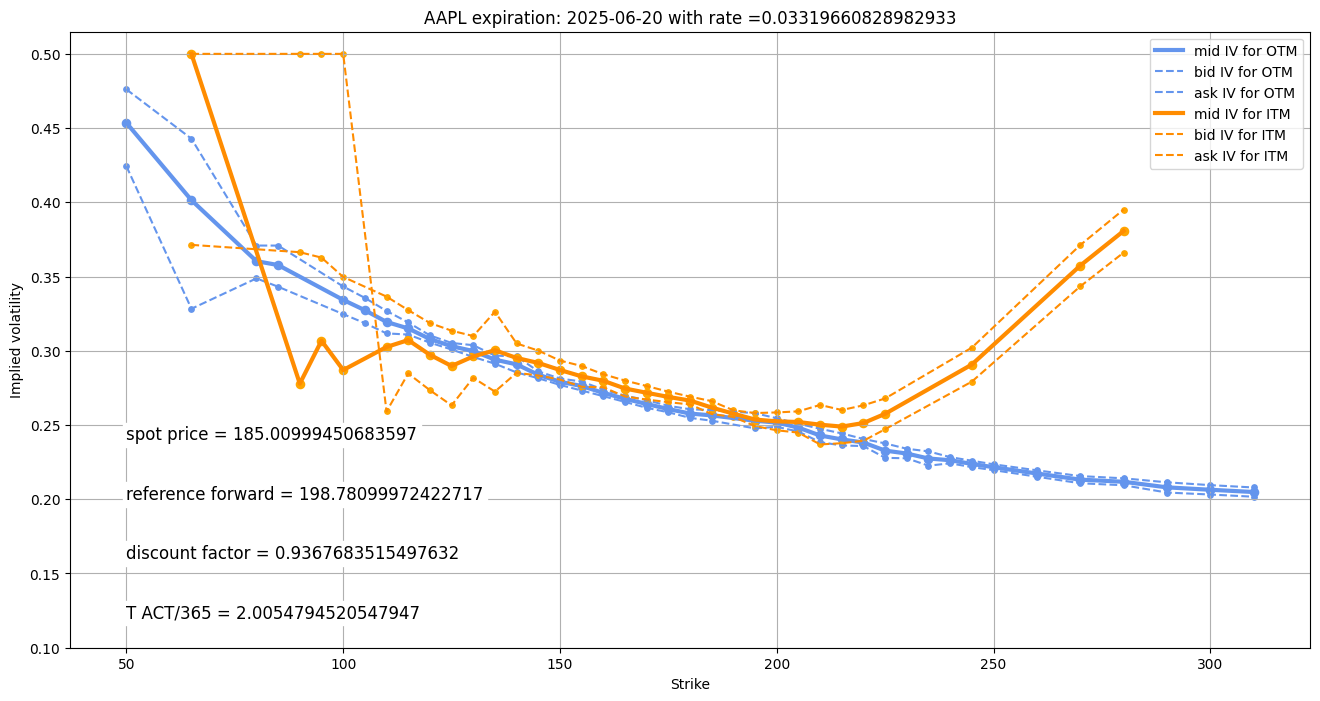

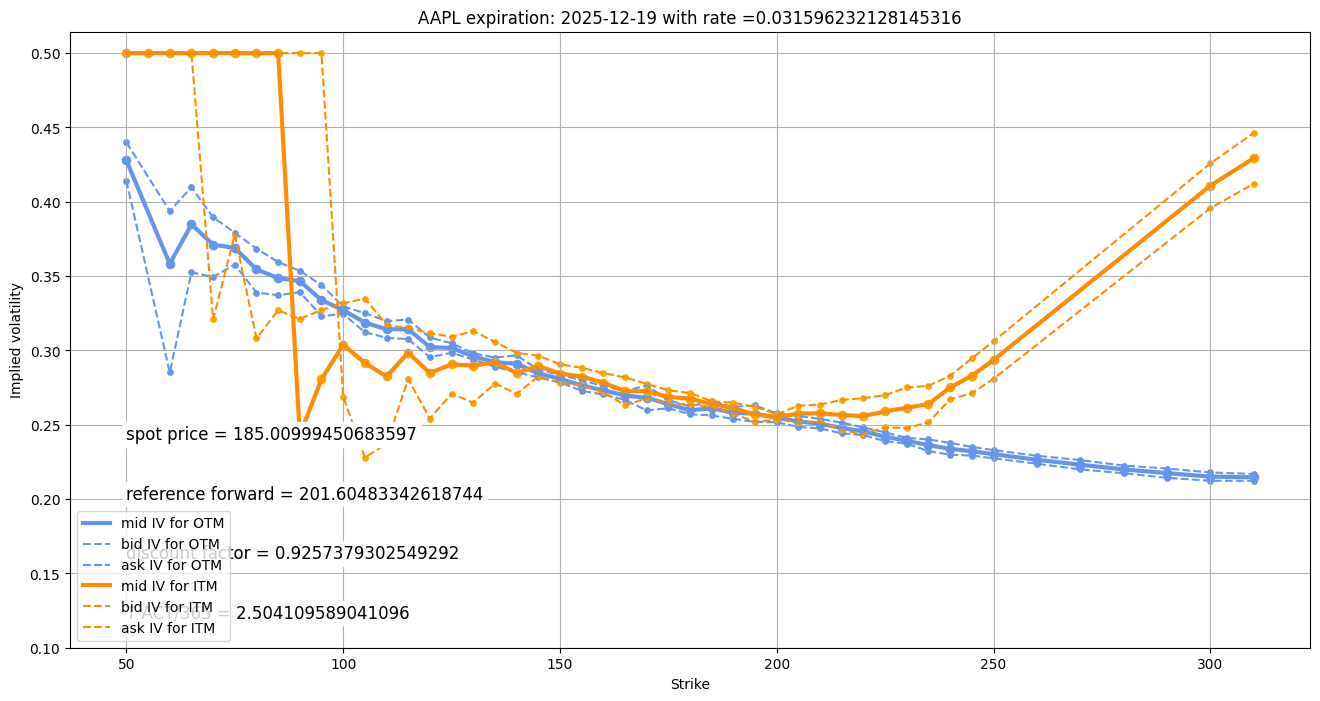

In [40]:
expiry_date_list= options_data["expiryDate"].unique()
for ind, expiry_date in enumerate(expiry_date_list):
    a = options_data.loc[(options_data['expiryDate'] == expiry_date)]
    strike_for_text = a['strike'].unique().min()
    reference_forward = Implied_Volatility['implied_volatility_surface'][ind]['reference_forward']
    discount_factor = Implied_Volatility['implied_volatility_surface'][ind]['reference_discount_factor']
    T_actual_365 = Implied_Volatility['implied_volatility_surface'][ind]['expiry_date_in_act365_year_fraction']
    data_date = datetime.strptime(options_data["lastTradeDate"].iloc[0], "%Y-%m-%d %H:%M:%S")
    T_actual_360 = ((datetime.strptime(expiry_date, "%Y-%m-%d") - data_date).days + 2)/360
    a = a.loc[((a["strike"] >= reference_forward) & (a["optionType"] == "calls")) | ((a["strike"] < reference_forward) & (a["optionType"] == 'puts'))]
    a = a.sort_values(by=['strike'])
    b = options_data.loc[(options_data['expiryDate'] == expiry_date)]
    b = b.loc[((b["strike"] <= reference_forward) & (b["optionType"] == "calls")) | ((b["strike"] > reference_forward) & (b["optionType"] == 'puts'))]
    b = b.sort_values(by=['strike'])
    a["mid_IV_out_df1"] = a.apply(lambda x: black_implied_vol(x.mid / discount_factor, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
    a["bid_IV_out_df1"] = a.apply(lambda x: black_implied_vol(x.bid / discount_factor, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
    a["ask_IV_out_df1"] = a.apply(lambda x: black_implied_vol(x.ask / discount_factor, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
    b["mid_IV_in_df1"] = b.apply(lambda x: black_implied_vol(x.mid / discount_factor, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
    b["bid_IV_in_df1"] = b.apply(lambda x: black_implied_vol(x.bid / discount_factor, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
    b["ask_IV_in_df1"] = b.apply(lambda x: black_implied_vol(x.ask / discount_factor, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
    plt.figure(figsize = (16,8), dpi=100)
    plt.plot(a['strike'], a["mid_IV_out_df1"], label='mid IV for OTM', color='cornflowerblue', linewidth=3)
    plt.plot(a['strike'], a["bid_IV_out_df1"], '--', label='bid IV for OTM', color='cornflowerblue')
    plt.plot(a['strike'], a["ask_IV_out_df1"], '--', label='ask IV for OTM', color='cornflowerblue')
    plt.plot(b['strike'], b["mid_IV_in_df1"], label='mid IV for ITM', color='darkorange', linewidth=3)
    plt.plot(b['strike'], b["bid_IV_in_df1"], '--', label='bid IV for ITM', color='darkorange')
    plt.plot(b['strike'], b["ask_IV_in_df1"], '--', label='ask IV for ITM', color='darkorange')
    plt.scatter(a['strike'], a["mid_IV_out_df1"], color='cornflowerblue',s=35)
    plt.scatter(a['strike'], a["bid_IV_out_df1"], color='cornflowerblue',s=15)
    plt.scatter(a['strike'], a["ask_IV_out_df1"], color='cornflowerblue',s=15)
    plt.scatter(b['strike'], b["mid_IV_in_df1"], color='orange',s=35)
    plt.scatter(b['strike'], b["bid_IV_in_df1"], color='orange',s=15)
    plt.scatter(b['strike'], b["ask_IV_in_df1"], color='orange',s=15)
    plt.title(ticker + ' expiration: ' + expiry_date + ' with rate =' + str((1 / discount_factor - 1) / T_actual_360))
    plt.ylabel(r'Implied volatility')
    plt.ylim(bottom=0.1)
    plt.xlabel(r'Strike')
    plt.legend()
    plt.grid()
    bbox_properties=dict(
    boxstyle="Square, pad=0.2", ec="w",fc="w")
    plt.text(strike_for_text, 0.24, 'spot price = ' + str(a['last close'].unique()[0]), fontsize=12, bbox=bbox_properties)
    plt.text(strike_for_text, 0.20, 'reference forward = ' + str(reference_forward), fontsize=12, bbox=bbox_properties)
    plt.text(strike_for_text, 0.16, 'discount factor = ' + str(discount_factor), fontsize=12, bbox=bbox_properties)
    plt.text(strike_for_text, 0.12, 'T ACT/365 = ' + str(T_actual_365), fontsize=12, bbox=bbox_properties)
    plt.show()
    

In [63]:
a['strike']

31    160.0
32    162.5
33    165.0
34    167.5
35    170.0
36    172.5
37    175.0
38    177.5
39    180.0
40    182.5
41    185.0
27    187.5
28    190.0
29    192.5
30    195.0
Name: strike, dtype: float64

In [29]:
Implied_Volatility['implied_volatility_surface'][10]

{'expiry_date': '2023-12-15',
 'number_of_days_from_value_date': 179.0,
 'expiry_date_in_act365_year_fraction': 0.4904109589041096,
 'reference_forward': 189.15304077261538,
 'reference_discount_factor': 0.9754750316586295,
 'strikes': [95.0,
  100.0,
  105.0,
  110.0,
  115.0,
  120.0,
  125.0,
  130.0,
  135.0,
  140.0,
  145.0,
  150.0,
  155.0,
  160.0,
  165.0,
  170.0,
  175.0,
  180.0,
  185.0,
  190.0,
  195.0,
  200.0,
  205.0,
  210.0,
  215.0,
  220.0,
  225.0,
  230.0,
  235.0,
  240.0,
  245.0,
  250.0,
  265.0,
  270.0,
  295.0],
 'mid_implied_volatilities': [0.45065169064867017,
  0.43439261957226505,
  0.4171696973423466,
  0.4017515758021903,
  0.3864076214968667,
  0.3719872640946825,
  0.3582581487279161,
  0.34378628039108855,
  0.3315598563983803,
  0.3188121509149092,
  0.3065105446204685,
  0.2940071764793434,
  0.28320105158093095,
  0.27307336466776255,
  0.26265249917229067,
  0.2531289363121936,
  0.2441737757541452,
  0.23606022840868396,
  0.228536081289942

spot price = 185.00999450683597
reference_forward = 189.15304077261538
discount_factor = 0.9777098230000488
T_actual_365 = 0.4904109589041096


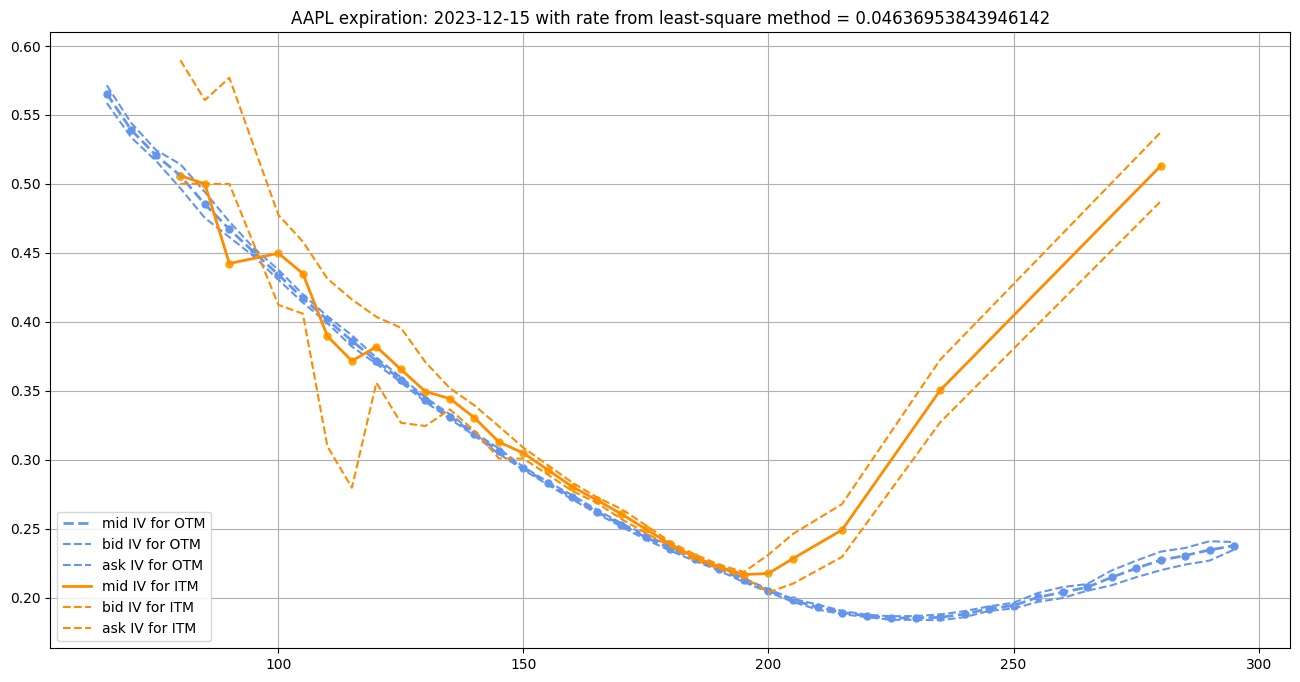

In [179]:
ind = 10
expiry_date = '2023-12-15'

reference_forward = Implied_Volatility['implied_volatility_surface'][ind]['reference_forward']
# reference_forward = 127
discount_factor1 = Implied_Volatility['implied_volatility_surface'][ind]['reference_discount_factor']
discount_factor1 = 0.9777098230000488
# discount_factor2 = 0.99999
# discount_factor3 = 0.800
T_actual_365 = Implied_Volatility['implied_volatility_surface'][ind]['expiry_date_in_act365_year_fraction']
data_date = datetime.strptime(options_data["lastTradeDate"].iloc[0], "%Y-%m-%d %H:%M:%S")
T_actual_360 = ((datetime.strptime(expiry_date, "%Y-%m-%d") - data_date).days)/360
a = options_data.loc[(options_data['expiryDate'] == expiry_date)]
a = a.loc[((a["strike"] >= reference_forward) & (a["optionType"] == "calls")) | ((a["strike"] < reference_forward) & (a["optionType"] == 'puts'))]
a = a.sort_values(by=['strike'])
b = options_data.loc[(options_data['expiryDate'] == expiry_date)]
b = b.loc[((b["strike"] <= reference_forward) & (b["optionType"] == "calls")) | ((b["strike"] > reference_forward) & (b["optionType"] == 'puts'))]
b = b.sort_values(by=['strike'])
a["mid_IV_out_df1"] = a.apply(lambda x: black_implied_vol(x.mid / discount_factor1, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
a["bid_IV_out_df1"] = a.apply(lambda x: black_implied_vol(x.bid / discount_factor1, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
a["ask_IV_out_df1"] = a.apply(lambda x: black_implied_vol(x.ask / discount_factor1, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
# a["mid_IV_out_df2"] = a.apply(lambda x: black_implied_vol(x.mid / discount_factor2, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
# a["bid_IV_out_df2"] = a.apply(lambda x: black_implied_vol(x.bid / discount_factor2, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
# a["ask_IV_out_df2"] = a.apply(lambda x: black_implied_vol(x.ask / discount_factor2, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
# a["mid_IV_out_df3"] = a.apply(lambda x: black_implied_vol(x.mid / discount_factor3, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
# a["bid_IV_out_df3"] = a.apply(lambda x: black_implied_vol(x.bid / discount_factor3, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
# a["ask_IV_out_df3"] = a.apply(lambda x: black_implied_vol(x.ask / discount_factor3, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
b["mid_IV_in_df1"] = b.apply(lambda x: black_implied_vol(x.mid / discount_factor1, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
b["bid_IV_in_df1"] = b.apply(lambda x: black_implied_vol(x.bid / discount_factor1, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
b["ask_IV_in_df1"] = b.apply(lambda x: black_implied_vol(x.ask / discount_factor1, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
# a["mid_IV_out_df2"] = a.apply(lambda x: black_implied_vol(x.mid / discount_factor2, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
# b["mid_IV_in_df2"] = b.apply(lambda x: black_implied_vol(x.mid / discount_factor2, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
plt.figure(figsize = (16,8))
plt.plot(a['strike'], a["mid_IV_out_df1"], '--', label='mid IV for OTM' , color='cornflowerblue', linewidth=2)
plt.plot(a['strike'], a["bid_IV_out_df1"], '--', label='bid IV for OTM', color='cornflowerblue')
plt.plot(a['strike'], a["ask_IV_out_df1"], '--', label='ask IV for OTM', color='cornflowerblue')
# plt.plot(a['strike'], a["mid_IV_out_df2"], ':', label='mid IV for OTM with rate =' + str((1 / discount_factor2 - 1) / T_actual_360), color='darkorange', linewidth=2)
# plt.plot(a['strike'], a["bid_IV_out_df2"], '--', label='bid IV for OTM', color='darkorange')
# plt.plot(a['strike'], a["ask_IV_out_df2"], '--', label='ask IV for OTM', color='darkorange')
# plt.plot(a['strike'], a["mid_IV_out_df3"], label='mid IV for OTM with rate =' + str((1 / discount_factor3 - 1) / T_actual_360), linewidth=2)
# plt.plot(a['strike'], a["bid_IV_out_df2"], '--', label='bid IV for OTM', color='plum')
# plt.plot(a['strike'], a["ask_IV_out_df2"], '--', label='ask IV for OTM', color='plum')
# plt.plot(a['strike'], a["mid_IV_out_df2"], label='IV from Black-76 model for out of the money option')
plt.plot(b['strike'], b["mid_IV_in_df1"], label='mid IV for ITM', color='darkorange', linewidth=2)
plt.plot(b['strike'], b["bid_IV_in_df1"], '--', label='bid IV for ITM', color='darkorange')
plt.plot(b['strike'], b["ask_IV_in_df1"], '--', label='ask IV for ITM', color='darkorange')
# # plt.plot(b['strike'], b["mid_IV_in_df2"], label='IV from Black-76 model for in the money option идф')
plt.scatter(a['strike'], a["mid_IV_out_df1"], color='cornflowerblue',s=25)
# plt.scatter(a['strike'], a["bid_IV_out_df1"], color='cornflowerblue',s=15)
# plt.scatter(a['strike'], a["ask_IV_out_df1"], color='cornflowerblue',s=15)
# plt.scatter(a['strike'], a["mid_IV_out_df2"], color='darkorange',s=25)
# plt.scatter(a['strike'], a["mid_IV_out_df3"], s=25)
# plt.scatter(a['strike'], a["bid_IV_out_df2"], color='darkorange',s=15)
# plt.scatter(a['strike'], a["ask_IV_out_df2"], color='darkorange',s=15)
# plt.scatter(a['strike'], a["mid_IV_out_df2"])
plt.scatter(b['strike'], b["mid_IV_in_df1"], color='orange',s=25)
# plt.scatter(b['strike'], b["bid_IV_in_df1"], color='orange',s=15)
# plt.scatter(b['strike'], b["ask_IV_in_df1"], color='orange',s=15)
# plt.scatter(b['strike'], b["mid_IV_in_df2"])
plt.title(ticker + ' expiration: ' + expiry_date + ' with rate from least-square method = ' + str((1 / discount_factor1 - 1) / T_actual_360))
print('spot price =', a['last close'].unique()[0])
# print('spot price with df =', a['last close'].unique()[0] / discount_factor2)
print('reference_forward =', reference_forward)
print('discount_factor =', discount_factor1)
print('T_actual_365 =', T_actual_365)
plt.legend()
plt.grid()
plt.show()

In [89]:
def get_what_i_need(discount_factor1):
    ind = 10
    expiry_date = '2023-12-15'
    reference_forward = Implied_Volatility['implied_volatility_surface'][ind]['reference_forward']
    # reference_forward = 127
    # discount_factor3 = 0.800
    T_actual_365 = Implied_Volatility['implied_volatility_surface'][ind]['expiry_date_in_act365_year_fraction']
    data_date = datetime.strptime(options_data["lastTradeDate"].iloc[0], "%Y-%m-%d %H:%M:%S")
    T_actual_360 = ((datetime.strptime(expiry_date, "%Y-%m-%d") - data_date).days)/360
    a = options_data.loc[(options_data['expiryDate'] == expiry_date)]
    a = a.loc[((a["strike"] >= reference_forward) & (a["optionType"] == "calls")) | ((a["strike"] < reference_forward) & (a["optionType"] == 'puts'))]
    a = a.sort_values(by=['strike'])
    b = options_data.loc[(options_data['expiryDate'] == expiry_date)]
    b = b.loc[((b["strike"] <= reference_forward) & (b["optionType"] == "calls")) | ((b["strike"] > reference_forward) & (b["optionType"] == 'puts'))]
    b = b.sort_values(by=['strike'])
    a["mid_IV_out_df1"] = a.apply(lambda x: black_implied_vol(x.mid / discount_factor1, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
    b["mid_IV_in_df1"] = b.apply(lambda x: black_implied_vol(x.mid / discount_factor1, reference_forward, x.strike, T_actual_365, x.optionType), axis=1)
    return a, b

In [172]:
diference_last = 10
diference = 9
# discount_factor = Implied_Volatility['implied_volatility_surface'][10]['reference_discount_factor']
discount_factor = 0.9777098000000495
reference_forward = Implied_Volatility['implied_volatility_surface'][10]['reference_forward']
while diference < diference_last:
    diference_last = diference
    diference  = 0
    a, b = get_what_i_need(discount_factor)
    strike_a = a['strike'].unique()
    strike_b = b['strike'].unique()
    for i in strike_a:
        if (i in strike_b) and i < reference_forward:
            diference += abs(b.loc[b['strike'] == i]['mid_IV_in_df1'].item() - a.loc[a['strike'] == i]['mid_IV_out_df1'].item())
    print('diference =',diference)
    print('diference_last =',diference_last)
    discount_factor += 0.000000001
    
            
    

diference = 0.20966904303314146
diference_last = 9
diference = 0.20966899244694856
diference_last = 0.20966904303314146
diference = 0.20966894186072732
diference_last = 0.20966899244694856
diference = 0.2096688912744915
diference_last = 0.20966894186072732
diference = 0.20966884068824343
diference_last = 0.2096688912744915
diference = 0.20966879010196798
diference_last = 0.20966884068824343
diference = 0.20966873951569204
diference_last = 0.20966879010196798
diference = 0.20966868892940224
diference_last = 0.20966873951569204
diference = 0.2096686383430889
diference_last = 0.20966868892940224
diference = 0.2096685877567663
diference_last = 0.2096686383430889
diference = 0.20966853717044648
diference_last = 0.2096685877567663
diference = 0.20966848658405648
diference_last = 0.20966853717044648
diference = 0.2096684359977025
diference_last = 0.20966848658405648
diference = 0.2096683854113095
diference_last = 0.2096684359977025
diference = 0.2096683348249291
diference_last = 0.20966838541

In [174]:
discount_factor 0.9777098230000488

0.9777098230000488

In [173]:
diference_last

0.20966798071965584

In [6]:
options_data.loc[options_data['expiryDate'] == '2023-09-15']

contractSymbol ticker        lastTradeDate  expiryDate  strike   
412  AAPL230915C00115000   AAPL  2023-06-20 16:45:11  2023-09-15   115.0  \
416  AAPL230915C00135000   AAPL  2023-06-20 15:24:20  2023-09-15   135.0   
417  AAPL230915C00140000   AAPL  2023-06-20 19:21:24  2023-09-15   140.0   
418  AAPL230915C00145000   AAPL  2023-06-20 14:01:58  2023-09-15   145.0   
419  AAPL230915C00150000   AAPL  2023-06-20 16:29:41  2023-09-15   150.0   
420  AAPL230915C00155000   AAPL  2023-06-20 19:12:25  2023-09-15   155.0   
421  AAPL230915C00160000   AAPL  2023-06-20 19:43:49  2023-09-15   160.0   
422  AAPL230915C00165000   AAPL  2023-06-20 18:30:06  2023-09-15   165.0   
423  AAPL230915C00170000   AAPL  2023-06-20 19:51:02  2023-09-15   170.0   
424  AAPL230915C00175000   AAPL  2023-06-20 19:54:40  2023-09-15   175.0   
425  AAPL230915C00180000   AAPL  2023-06-20 19:58:38  2023-09-15   180.0   
426  AAPL230915C00185000   AAPL  2023-06-20 19:58:23  2023-09-15   185.0   
427  AAPL230915C00190000   AAPL  2023-06-20 19:56:19  2023-09-15   190.0   
428  AAPL230915C00195000   AAPL  2023-06-20 19:59:37  2023-09-15   195.0   
429  AAPL230915C00200000   AAPL  2023-06-20 19:58:38  2023-09-15   200.0   
430  AAPL230915C00205000   AAPL  2023-06-20 19:58:24  2023-09-15   205.0   
431  AAPL230915C00210000   AAPL  2023-06-20 19:56:19  2023-09-15   210.0   
432  AAPL230915C00220000   AAPL  2023-06-20 19:51:18  2023-09-15   220.0   
433  AAPL230915C00230000   AAPL  2023-06-20 19:45:46  2023-09-15   230.0   
434  AAPL230915C00240000   AAPL  2023-06-20 16:49:52  2023-09-15   240.0   
435  AAPL230915C00250000   AAPL  2023-06-20 19:44:50  2023-09-15   250.0   
436  AAPL230915C00260000   AAPL  2023-06-20 13:38:03  2023-09-15   260.0   
437  AAPL230915C00270000   AAPL  2023-06-20 19:33:05  2023-09-15   270.0   
438  AAPL230915C00280000   AAPL  2023-06-20 18:54:19  2023-09-15   280.0   
439  AAPL230915C00290000   AAPL  2023-06-20 17:28:11  2023-09-15   290.0   
440  AAPL230915C00300000   AAPL  2023-06-20 18:09:31  2023-09-15   300.0   
443  AAPL230915P00080000   AAPL  2023-06-20 16:17:00  2023-09-15    80.0   
444  AAPL230915P00085000   AAPL  2023-06-20 19:58:31  2023-09-15    85.0   
445  AAPL230915P00090000   AAPL  2023-06-20 18:50:55  2023-09-15    90.0   
447  AAPL230915P00100000   AAPL  2023-06-20 19:21:42  2023-09-15   100.0   
448  AAPL230915P00105000   AAPL  2023-06-20 14:39:20  2023-09-15   105.0   
449  AAPL230915P00110000   AAPL  2023-06-20 17:50:42  2023-09-15   110.0   
450  AAPL230915P00115000   AAPL  2023-06-20 19:33:40  2023-09-15   115.0   
451  AAPL230915P00120000   AAPL  2023-06-20 18:30:53  2023-09-15   120.0   
452  AAPL230915P00125000   AAPL  2023-06-20 18:08:36  2023-09-15   125.0   
453  AAPL230915P00130000   AAPL  2023-06-20 19:52:02  2023-09-15   130.0   
454  AAPL230915P00135000   AAPL  2023-06-20 19:53:16  2023-09-15   135.0   
455  AAPL230915P00140000   AAPL  2023-06-20 19:54:01  2023-09-15   140.0   
456  AAPL230915P00145000   AAPL  2023-06-20 19:48:58  2023-09-15   145.0   
457  AAPL230915P00150000   AAPL  2023-06-20 19:59:33  2023-09-15   150.0   
458  AAPL230915P00155000   AAPL  2023-06-20 19:58:27  2023-09-15   155.0   
459  AAPL230915P00160000   AAPL  2023-06-20 19:32:21  2023-09-15   160.0   
460  AAPL230915P00165000   AAPL  2023-06-20 19:59:59  2023-09-15   165.0   
461  AAPL230915P00170000   AAPL  2023-06-20 19:55:16  2023-09-15   170.0   
462  AAPL230915P00175000   AAPL  2023-06-20 19:54:35  2023-09-15   175.0   
463  AAPL230915P00180000   AAPL  2023-06-20 19:55:48  2023-09-15   180.0   
464  AAPL230915P00185000   AAPL  2023-06-20 19:50:00  2023-09-15   185.0   
465  AAPL230915P00190000   AAPL  2023-06-20 19:54:40  2023-09-15   190.0   
466  AAPL230915P00195000   AAPL  2023-06-20 19:59:46  2023-09-15   195.0   
467  AAPL230915P00200000   AAPL  2023-06-20 16:42:13  2023-09-15   200.0   
468  AAPL230915P00205000   AAPL  2023-06-20 17:39:25  2023-09-15   205.0   
469  AAPL230915P00210000   AAPL  2023-06-20 19:14:17  2023

In [157]:
b


contractSymbol ticker        lastTradeDate  expiryDate  strike   
656  AAPL231215C00080000   AAPL  2023-06-15 13:49:27  2023-12-15    80.0  \
657  AAPL231215C00085000   AAPL  2023-06-15 14:56:06  2023-12-15    85.0   
658  AAPL231215C00090000   AAPL  2023-06-15 19:03:17  2023-12-15    90.0   
660  AAPL231215C00100000   AAPL  2023-06-20 15:34:05  2023-12-15   100.0   
661  AAPL231215C00105000   AAPL  2023-06-15 17:13:20  2023-12-15   105.0   
662  AAPL231215C00110000   AAPL  2023-06-16 13:58:34  2023-12-15   110.0   
663  AAPL231215C00115000   AAPL  2023-06-14 17:10:14  2023-12-15   115.0   
664  AAPL231215C00120000   AAPL  2023-06-15 14:32:46  2023-12-15   120.0   
665  AAPL231215C00125000   AAPL  2023-06-13 18:17:13  2023-12-15   125.0   
666  AAPL231215C00130000   AAPL  2023-06-20 18:26:24  2023-12-15   130.0   
667  AAPL231215C00135000   AAPL  2023-06-20 19:24:18  2023-12-15   135.0   
668  AAPL231215C00140000   AAPL  2023-06-20 15:31:29  2023-12-15   140.0   
669  AAPL231215C00145000   AAPL  2023-06-20 19:24:18  2023-12-15   145.0   
670  AAPL231215C00150000   AAPL  2023-06-20 18:24:58  2023-12-15   150.0   
671  AAPL231215C00155000   AAPL  2023-06-20 19:13:32  2023-12-15   155.0   
672  AAPL231215C00160000   AAPL  2023-06-20 19:27:00  2023-12-15   160.0   
673  AAPL231215C00165000   AAPL  2023-06-20 16:16:31  2023-12-15   165.0   
674  AAPL231215C00170000   AAPL  2023-06-20 17:21:41  2023-12-15   170.0   
675  AAPL231215C00175000   AAPL  2023-06-20 19:59:59  2023-12-15   175.0   
676  AAPL231215C00180000   AAPL  2023-06-20 19:12:57  2023-12-15   180.0   
677  AAPL231215C00185000   AAPL  2023-06-20 19:50:38  2023-12-15   185.0   
725  AAPL231215P00190000   AAPL  2023-06-20 19:35:05  2023-12-15   190.0   
726  AAPL231215P00195000   AAPL  2023-06-20 13:41:18  2023-12-15   195.0   
727  AAPL231215P00200000   AAPL  2023-06-20 19:24:26  2023-12-15   200.0   
728  AAPL231215P00205000   AAPL  2023-06-16 19:27:33  2023-12-15   205.0   
730  AAPL231215P00215000   AAPL  2023-06-14 18:00:25  2023-12-15   215.0   
732  AAPL231215P00235000   AAPL  2023-06-20 14:20:28  2023-12-15   235.0   
734  AAPL231215P00280000   AAPL  2023-06-12 19:49:39  2023-12-15   280.0   

     lastPrice     bid     ask      mid  volume  openInterest   
656     106.23  106.60  107.05  106.825     6.0            37  \
657     102.05  101.45  102.20  101.825     2.0            50   
658      98.10   96.50   97.60   97.050     5.0           556   
660      87.40   87.35   87.65   87.500     1.0           914   
661      82.23   82.55   82.85   82.700     1.0           199   
662      77.85   77.45   78.00   77.725     3.0           509   
663      71.85   72.55   73.25   72.900     1.0           105   
664      68.50   68.10   68.55   68.325     1.0           170   
665      61.65   63.20   63.95   63.575    29.0           459   
666      59.62   58.55   59.15   58.850     1.0           860   
667      54.56   54.20   54.45   54.325     2.0          2376   
668      49.60   49.55   49.90   49.725     4.0          5885   
669      45.44   44.85   45.35   45.100     6.0          2768   
670      41.25   40.65   40.85   40.750     3.0          8308   
671      36.50   36.30   36.50   36.400    76.0          6023   
672      32.29   32.05   32.25   32.150     8.0          9030   
673      28.20   28.05   28.20   28.125   161.0          5706   
674      24.85   24.10   24.40   24.250     6.0          8950   
675      20.47   20.40   20.65   20.525   143.0         19722   
676      17.20   16.95   17.10   17.025     9.0          7367   
677      14.05   13.75   13.95   13.850    82.0          5689   
725      11.80   11.85   12.00   11.925   223.0          2238   
726      14.05   14.35   14.55   14.450   191.0           721   
727      17.39   16.95   18.30   17.625    12.0          5344   
728      21.10   20.70   22.40   21.550     1.0           306   
730      31.55   29.10   30.70   29.900     2.0             0   
732      49.35   49.15   50.90   50.025     1.0   

In [20]:
b['mid'] / discount_factor1

488    88.053501
494    58.465903
495    53.551525
496    48.763806
498    39.289695
499    34.501976
501    25.813152
502    21.658729
503    17.782957
504    14.160503
505    10.867362
555    10.158071
556    12.969906
557    16.440369
Name: mid, dtype: float64

In [32]:
b['bid'] / discount_factor1

488    87.800182
494    58.263249
495    53.298207
496    48.637147
498    39.163036
499    34.299321
501    25.686493
502    21.582734
503    17.681629
504    14.084507
505    10.791367
555    10.082075
556    12.868578
557    16.313710
Name: bid, dtype: float64

In [31]:
 black_implied_vol(88.306819, reference_forward, 100, T_actual_365, 'calls')

0.5487841974369513

In [53]:
black_implied_vol(87.91000, reference_forward, 100, T_actual_365, 'calls')

0.4264764247904174
0.37105263974067526
0.3152010650215933
0.17560206251193117
-63897.58980708252


0.5

In [58]:
black_price_formula(reference_forward, 100, T_actual_365, 0.00000070237123260601, 'calls')

87.91978052381853

In [17]:
black_implied_vol(x.mid / discount_factor1, reference_forward, x.strike, T_actual_365, x.optionType)

0.9945676103375635

In [51]:
#---------------------------------
#Functions compute implied volatility via Newton Raphson method for given parameters   
def black_implied_vol(undiscounted_price, F, K, T, optionType, initial_guess = 0.5):
    target_price = undiscounted_price
    eps = 1.0 if optionType == 'calls' else -1.0
    MAX_ITERATIONS = 200
    PRECISION = min(1.0e-5, target_price/F)
    sigma = initial_guess
    for i in range(0, MAX_ITERATIONS):
        stddev = sigma*np.sqrt(T)
        d1 = np.log(F/K)/stddev + 0.5*stddev
        d2 = d1 - stddev
        price = eps *(F * norm.cdf(eps*d1) - K * norm.cdf(eps*d2))
        vega = F * norm.pdf(d1) * np.sqrt(T)
        diff = target_price - price
        if (vega<=np.finfo(float).eps):
            return initial_guess #likely to be far off the money anyway....
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # Newton–Raphson
        print(sigma)
    return sigma # if MAX_ITERATIONS, return estimate so far

def black_price_formula(F, K, T, sigma, optionType):
    stddev = sigma*np.sqrt(T)
    d1 = np.log(F/K)/stddev + 0.5*stddev
    d2 = d1 - stddev
    eps = 1.0 if optionType == 'calls' else -1.0
    return eps *(F * norm.cdf(eps*d1) - K * norm.cdf(eps*d2))

In [20]:
(options_data.loc[(options_data['expiryDate'] == '2023-10-20')])

contractSymbol ticker        lastTradeDate  expiryDate  strike   
479  AAPL231020C00125000   AAPL  2023-06-21 17:51:30  2023-10-20   125.0  \
482  AAPL231020C00140000   AAPL  2023-06-21 13:40:05  2023-10-20   140.0   
485  AAPL231020C00155000   AAPL  2023-06-21 14:53:00  2023-10-20   155.0   
487  AAPL231020C00165000   AAPL  2023-06-21 16:12:51  2023-10-20   165.0   
488  AAPL231020C00170000   AAPL  2023-06-21 19:18:35  2023-10-20   170.0   
489  AAPL231020C00175000   AAPL  2023-06-21 18:58:21  2023-10-20   175.0   
490  AAPL231020C00180000   AAPL  2023-06-21 19:52:27  2023-10-20   180.0   
491  AAPL231020C00185000   AAPL  2023-06-21 19:41:46  2023-10-20   185.0   
492  AAPL231020C00190000   AAPL  2023-06-21 19:43:31  2023-10-20   190.0   
493  AAPL231020C00195000   AAPL  2023-06-21 19:53:50  2023-10-20   195.0   
494  AAPL231020C00200000   AAPL  2023-06-21 19:54:16  2023-10-20   200.0   
495  AAPL231020C00205000   AAPL  2023-06-21 19:39:17  2023-10-20   205.0   
496  AAPL231020C00210000   AAPL  2023-06-21 19:59:00  2023-10-20   210.0   
497  AAPL231020C00215000   AAPL  2023-06-21 19:01:36  2023-10-20   215.0   
498  AAPL231020C00220000   AAPL  2023-06-21 19:39:04  2023-10-20   220.0   
499  AAPL231020C00225000   AAPL  2023-06-21 15:15:44  2023-10-20   225.0   
500  AAPL231020C00230000   AAPL  2023-06-21 18:26:41  2023-10-20   230.0   
501  AAPL231020C00235000   AAPL  2023-06-21 14:49:06  2023-10-20   235.0   
502  AAPL231020C00240000   AAPL  2023-06-21 16:23:28  2023-10-20   240.0   
503  AAPL231020C00245000   AAPL  2023-06-21 16:44:37  2023-10-20   245.0   
504  AAPL231020C00250000   AAPL  2023-06-21 17:06:46  2023-10-20   250.0   
505  AAPL231020C00255000   AAPL  2023-06-21 16:27:46  2023-10-20   255.0   
520  AAPL231020P00085000   AAPL  2023-06-21 17:18:31  2023-10-20    85.0   
521  AAPL231020P00090000   AAPL  2023-06-21 17:18:57  2023-10-20    90.0   
522  AAPL231020P00095000   AAPL  2023-06-21 17:19:22  2023-10-20    95.0   
523  AAPL231020P00100000   AAPL  2023-06-21 17:20:06  2023-10-20   100.0   
524  AAPL231020P00105000   AAPL  2023-06-21 17:20:17  2023-10-20   105.0   
525  AAPL231020P00110000   AAPL  2023-06-21 18:36:24  2023-10-20   110.0   
526  AAPL231020P00115000   AAPL  2023-06-21 19:17:01  2023-10-20   115.0   
527  AAPL231020P00120000   AAPL  2023-06-21 19:36:00  2023-10-20   120.0   
528  AAPL231020P00125000   AAPL  2023-06-21 19:36:29  2023-10-20   125.0   
529  AAPL231020P00130000   AAPL  2023-06-21 19:47:01  2023-10-20   130.0   
530  AAPL231020P00135000   AAPL  2023-06-21 19:53:42  2023-10-20   135.0   
531  AAPL231020P00140000   AAPL  2023-06-21 19:50:57  2023-10-20   140.0   
532  AAPL231020P00145000   AAPL  2023-06-21 19:29:13  2023-10-20   145.0   
533  AAPL231020P00150000   AAPL  2023-06-21 19:57:58  2023-10-20   150.0   
534  AAPL231020P00155000   AAPL  2023-06-21 18:56:19  2023-10-20   155.0   
535  AAPL231020P00160000   AAPL  2023-06-21 19:56:56  2023-10-20   160.0   
536  AAPL231020P00165000   AAPL  2023-06-21 19:22:36  2023-10-20   165.0   
537  AAPL231020P00170000   AAPL  2023-06-21 18:19:29  2023-10-20   170.0   
538  AAPL231020P00175000   AAPL  2023-06-21 19:57:27  2023-10-20   175.0   
539  AAPL231020P00180000   AAPL  2023-06-21 19:59:17  2023-10-20   180.0   
540  AAPL231020P00185000   AAPL  2023-06-21 19:55:21  2023-10-20   185.0   
541  AAPL231020P00190000   AAPL  2023-06-21 18:33:31  2023-10-20   190.0   
542  AAPL231020P00195000   AAPL  2023-06-21 15:03:30  2023-10-20   195.0   
543  AAPL231020P00200000   AAPL  2023-06-21 19:05:54  2023-10-20   200.0   

     lastPrice    bid    ask     mid  volume  openInterest  impliedVolatility   
479      61.82  61.15  61.55  61.350     2.0           194           0.536870  \
482      48.15  46.80  47.10  46.950     6.0           891           0.449590   
485      32.53  32.95  33.10  33.025     1.0          4043           0.363349   
487      23.92  24.15  24.40  24.275    17.0          4303           0.317146   
488      20.85  20.25  20.40  20

In [10]:
pd.read_csv('AAPL_expiration_on_2023-10-20.csv')

contractSymbol ticker        lastTradeDate  expiryDate  strike   
0   AAPL231020C00100000   AAPL  2023-06-20 17:22:18  2023-10-20   100.0  \
1   AAPL231020C00130000   AAPL  2023-06-20 15:12:30  2023-10-20   130.0   
2   AAPL231020C00135000   AAPL  2023-06-20 13:48:51  2023-10-20   135.0   
3   AAPL231020C00140000   AAPL  2023-06-20 19:14:19  2023-10-20   140.0   
4   AAPL231020C00150000   AAPL  2023-06-20 19:01:55  2023-10-20   150.0   
5   AAPL231020C00155000   AAPL  2023-06-20 19:01:55  2023-10-20   155.0   
6   AAPL231020C00165000   AAPL  2023-06-20 16:05:02  2023-10-20   165.0   
7   AAPL231020C00170000   AAPL  2023-06-20 16:51:04  2023-10-20   170.0   
8   AAPL231020C00175000   AAPL  2023-06-20 19:54:40  2023-10-20   175.0   
9   AAPL231020C00180000   AAPL  2023-06-20 19:53:55  2023-10-20   180.0   
10  AAPL231020C00185000   AAPL  2023-06-20 19:54:40  2023-10-20   185.0   
11  AAPL231020C00190000   AAPL  2023-06-20 19:58:49  2023-10-20   190.0   
12  AAPL231020C00195000   AAPL  2023-06-20 19:59:30  2023-10-20   195.0   
13  AAPL231020C00200000   AAPL  2023-06-20 19:55:04  2023-10-20   200.0   
14  AAPL231020C00205000   AAPL  2023-06-20 19:56:09  2023-10-20   205.0   
15  AAPL231020C00210000   AAPL  2023-06-20 19:53:06  2023-10-20   210.0   
16  AAPL231020C00215000   AAPL  2023-06-20 19:20:24  2023-10-20   215.0   
17  AAPL231020C00220000   AAPL  2023-06-20 18:45:43  2023-10-20   220.0   
18  AAPL231020C00225000   AAPL  2023-06-20 17:38:32  2023-10-20   225.0   
19  AAPL231020C00230000   AAPL  2023-06-20 18:59:41  2023-10-20   230.0   
20  AAPL231020C00235000   AAPL  2023-06-20 19:44:42  2023-10-20   235.0   
21  AAPL231020C00240000   AAPL  2023-06-20 18:46:49  2023-10-20   240.0   
22  AAPL231020C00250000   AAPL  2023-06-20 13:50:14  2023-10-20   250.0   
23  AAPL231020C00255000   AAPL  2023-06-20 19:53:03  2023-10-20   255.0   
24  AAPL231020C00260000   AAPL  2023-06-20 14:12:09  2023-10-20   260.0   
25  AAPL231020C00295000   AAPL  2023-06-20 18:00:34  2023-10-20   295.0   
26  AAPL231020P00070000   AAPL  2023-06-20 14:47:34  2023-10-20    70.0   
27  AAPL231020P00075000   AAPL  2023-06-20 15:41:29  2023-10-20    75.0   
28  AAPL231020P00085000   AAPL  2023-06-20 15:54:37  2023-10-20    85.0   
29  AAPL231020P00090000   AAPL  2023-06-20 17:38:06  2023-10-20    90.0   
30  AAPL231020P00105000   AAPL  2023-06-20 15:31:10  2023-10-20   105.0   
31  AAPL231020P00110000   AAPL  2023-06-20 18:51:10  2023-10-20   110.0   
32  AAPL231020P00115000   AAPL  2023-06-20 19:37:57  2023-10-20   115.0   
33  AAPL231020P00120000   AAPL  2023-06-20 19:33:27  2023-10-20   120.0   
34  AAPL231020P00125000   AAPL  2023-06-20 19:33:27  2023-10-20   125.0   
35  AAPL231020P00130000   AAPL  2023-06-20 19:44:28  2023-10-20   130.0   
36  AAPL231020P00135000   AAPL  2023-06-20 19:55:01  2023-10-20   135.0   
37  AAPL231020P00140000   AAPL  2023-06-20 19:27:04  2023-10-20   140.0   
38  AAPL231020P00145000   AAPL  2023-06-20 18:35:30  2023-10-20   145.0   
39  AAPL231020P00150000   AAPL  2023-06-20 19:54:54  2023-10-20   150.0   
40  AAPL231020P00155000   AAPL  2023-06-20 19:16:07  2023-10-20   155.0   
41  AAPL231020P00160000   AAPL  2023-06-20 19:41:56  2023-10-20   160.0   
42  AAPL231020P00165000   AAPL  2023-06-20 19:24:22  2023-10-20   165.0   
43  AAPL231020P00170000   AAPL  2023-06-20 19:51:17  2023-10-20   170.0   
44  AAPL231020P00175000   AAPL  2023-06-20 19:54:27  2023-10-20   175.0   
45  AAPL231020P00180000   AAPL  2023-06-20 19:12:10  2023-10-20   180.0   
46  AAPL231020P00185000   AAPL  2023-06-20 19:54:40  2023-10-20   185.0   
47  AAPL231020P00190000   AAPL  2023-06-20 17:58:25  2023-10-20   190.0   
48  AAPL231020P00195000   AAPL  2023-06-20 17:42:41  2023-10-20   195.0   
49  AAPL231020P00200000   AAPL  2023-06-20 19:59:45  2023-10-20   200.0   

    lastPrice    bid    ask     mid  volume  openInterest  impliedVolatility   
0       87.60  86.65  87.15  86.900     1.0           163           0.733157  \
1       57.65  57.50  5

In [18]:
(1 / discount_factor - 1) / T_actual_360

0.039492559136255476

In [31]:
strike = 235
options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date)]

contractSymbol ticker        lastTradeDate  expiryDate  strike   
687  AAPL231215C00235000   AAPL  2023-06-20 14:20:59  2023-12-15   235.0  \
732  AAPL231215P00235000   AAPL  2023-06-20 14:20:28  2023-12-15   235.0   

     lastPrice    bid    ask     mid  volume  openInterest  impliedVolatility   
687       0.52   0.50   0.56   0.530     3.0          8896           0.202645  \
732      49.35  49.15  50.90  50.025     1.0             0           0.224983   

     last close optionType  yFinance_dividend_yield  
687  185.009995      calls                 0.004973  
732  185.009995       puts                 0.004973

In [53]:
235.0 - 185.009995

49.990005

In [58]:
discount_factor = 1 / discount_factor

In [12]:
discount_factor = 1 / discount_factor 

In [51]:
(( - (options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'calls')]['ask'].item()) + (options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'puts')]['bid'].item()) + a['last close'].unique()[0]) * discount_factor - strike) * 100

3.4663919892750528

In [128]:
discount_factor = 1.0251415644126431

In [130]:
discount_factor =1

In [131]:
1 / discount_factor

1.0

In [132]:
(discount_factor - 1) / T_actual_360

0.0

In [133]:
(49.15 + 185.009995-0.56) * discount_factor - 235

-1.400004999999993

In [126]:
discount_factor = 1.00597

In [127]:
1 / discount_factor

0.9940654293865622

In [117]:
(discount_factor - 1) / T_actual_360 

0.012142372881355995

In [118]:
(49.15 + 185.009995-0.56) * discount_factor - 235

-0.005413029849989925

In [ ]:
print(- (options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'calls')]['ask'].item()))

In [50]:
(discount_factor - 1) / T_actual_360

In [37]:
discount_factor

1.0251415644126431

In [46]:
(options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'puts')]['bid'].item()) - (options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'calls')]['ask'].item() + strike / discount_factor -  a['last close'].unique()[0])

0.7960700042848927

In [ ]:
28.05

In [44]:
#left side call put parity (C + K * e^(-rT))
(options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'calls')]['ask'].item()) + strike / discount_factor

150.63392877501198

In [45]:
#right side call put parity (P + S)
(options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'puts')]['ask'].item()) + a['last close'].unique()[0]

151.72999877929686

In [51]:
print( (options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'calls')]['ask'].item()))
print((options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'puts')]['bid'].item()))
print(a['last close'].unique()[0])

5.0
25.65
125.77999877929688


In [158]:
(options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'calls')]['ask'].item())-(options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'puts')]['ask'].item())

-29.009999999999998

In [159]:
- strike / discount_factor + a['last close'].unique()[0]

-27.775236705674402

In [151]:
 - ((options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'calls')]['ask'].item()) + strike / discount_factor) + (options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'puts')]['ask'].item()) + a['last close'].unique()[0]

1.234763294325603

In [135]:
print(black_implied_vol(options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'calls')]['mid'].item() * discount_factor, reference_forward, strike, T_actual_365, 'calls'))
print(black_implied_vol(options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'puts')]['mid'].item() * discount_factor, reference_forward, strike, T_actual_365, 'puts'))

0.3400896198003315
0.45967470758559303


In [136]:
#for in the money put (right side)
print(black_price_formula(reference_forward, strike, T_actual_365, black_implied_vol(options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'calls')]['mid'].item() * discount_factor, reference_forward, strike, T_actual_365, 'calls'), 'puts') / discount_factor)

28.034624247527308


In [132]:
#for in the money call (left side)
print(black_price_formula(reference_forward, strike, T_actual_365, black_implied_vol(options_data.loc[(options_data['strike'] == strike) & (options_data['expiryDate'] == expiry_date) & (options_data['optionType'] == 'puts')]['mid'].item() * discount_factor, reference_forward, strike, T_actual_365, 'puts'), 'calls') / discount_factor)


0.8552809095283305


In [36]:
options_data.loc[(options_data['optionType'] == 'calls') & (options_data['expiryDate'] == '2023-10-20')]

contractSymbol ticker        lastTradeDate  expiryDate  strike   
273  AAPL230721C00090000   AAPL  2023-06-14 19:48:25  2023-07-21    90.0  \
275  AAPL230721C00100000   AAPL  2023-06-14 18:44:52  2023-07-21   100.0   
278  AAPL230721C00115000   AAPL  2023-06-14 17:14:26  2023-07-21   115.0   
280  AAPL230721C00125000   AAPL  2023-06-14 18:08:14  2023-07-21   125.0   
281  AAPL230721C00130000   AAPL  2023-06-14 14:30:47  2023-07-21   130.0   
282  AAPL230721C00135000   AAPL  2023-06-14 18:05:52  2023-07-21   135.0   
283  AAPL230721C00140000   AAPL  2023-06-14 18:11:54  2023-07-21   140.0   
284  AAPL230721C00145000   AAPL  2023-06-14 19:57:18  2023-07-21   145.0   
285  AAPL230721C00150000   AAPL  2023-06-14 18:58:10  2023-07-21   150.0   
286  AAPL230721C00155000   AAPL  2023-06-14 19:30:39  2023-07-21   155.0   
287  AAPL230721C00160000   AAPL  2023-06-14 19:45:36  2023-07-21   160.0   
288  AAPL230721C00165000   AAPL  2023-06-14 19:58:36  2023-07-21   165.0   
289  AAPL230721C00170000   AAPL  2023-06-14 19:59:33  2023-07-21   170.0   
290  AAPL230721C00175000   AAPL  2023-06-14 19:56:36  2023-07-21   175.0   
291  AAPL230721C00180000   AAPL  2023-06-14 19:59:43  2023-07-21   180.0   
292  AAPL230721C00185000   AAPL  2023-06-14 19:59:56  2023-07-21   185.0   
293  AAPL230721C00190000   AAPL  2023-06-14 19:58:20  2023-07-21   190.0   
294  AAPL230721C00195000   AAPL  2023-06-14 19:59:03  2023-07-21   195.0   
295  AAPL230721C00200000   AAPL  2023-06-14 19:59:05  2023-07-21   200.0   
296  AAPL230721C00205000   AAPL  2023-06-14 19:53:11  2023-07-21   205.0   
297  AAPL230721C00210000   AAPL  2023-06-14 19:42:28  2023-07-21   210.0   
298  AAPL230721C00215000   AAPL  2023-06-14 18:52:06  2023-07-21   215.0   
299  AAPL230721C00220000   AAPL  2023-06-14 19:54:29  2023-07-21   220.0   
300  AAPL230721C00225000   AAPL  2023-06-14 15:38:33  2023-07-21   225.0   
301  AAPL230721C00230000   AAPL  2023-06-14 16:53:58  2023-07-21   230.0   
302  AAPL230721C00240000   AAPL  2023-06-14 18:16:39  2023-07-21   240.0   
303  AAPL230721C00250000   AAPL  2023-06-14 13:54:26  2023-07-21   250.0   

     lastPrice    bid    ask     mid   volume  openInterest   
273      94.12  93.90  95.35  94.625      1.0        1072.0  \
275      84.55  83.50  85.25  84.375      2.0         208.0   
278      69.34  69.35  69.70  69.525      1.0         411.0   
280      59.10  59.35  59.85  59.600     11.0        1392.0   
281      55.06  54.45  54.90  54.675     10.0        1657.0   
282      48.45  49.55  49.85  49.700    217.0        2789.0   
283      43.50  44.65  44.90  44.775     17.0        2430.0   
284      39.58  39.70  40.00  39.850     17.0        4011.0   
285      34.54  34.80  35.00  34.900     32.0        6430.0   
286      29.40  29.85  30.10  29.975     89.0       10506.0   
287      24.95  24.90  25.25  25.075    280.0       17680.0   
288      20.00  20.10  20.50  20.300    177.0       17492.0   
289      15.50  15.40  15.65  15.525    311.0       33537.0   
290      10.80  10.95  11.20  11.075   1371.0       71589.0   
291       7.19   7.15   7.30   7.225  22334.0       53450.0   
292       4.05   3.95   4.05   4.000   5313.0       46106.0   
293       1.76   1.82   1.85   1.835   7166.0       32916.0   
294       0.72   0.72   0.74   0.730   5212.0       28296.0   
295       0.28   0.27   0.29   0.280   4965.0       48820.0   
296       0.12   0.12   0.13   0.125   1602.0       15678.0   
297       0.07   0.06   0.08   0.070    299.0        6279.0   
298       0.06   0.03   0.06   0.045     23.0        3261.0   
299       0.05   0.04   0.04   0.040     90.0        7799.0   
300       0.04   0.02   0.04   0.030     25.0        1530.0   
301       0.02   0.02   0.04   0.030    217.0        5035.0   
302       0.02   0.01   0.03   0.020     20.0        1281.0   
303       0.02   0.01   0.04   0.025     19.0        1364.0   

     impliedVolatility  last close optionType  yFinance_dividend_yield  
273           1.216801  183.949997      cal

In [ ]:
F, K, T, sigma, optionType)

In [107]:
options_data.loc[(options_data['strike'] == 230) & (options_data['expiryDate'] == '2024-06-21')]

contractSymbol ticker        lastTradeDate  expiryDate  strike   
1002  AAPL240621C00230000   AAPL  2023-06-14 17:40:28  2024-06-21   230.0  \
1054  AAPL240621P00230000   AAPL  2023-06-07 14:50:40  2024-06-21   230.0   

      lastPrice    bid    ask     mid  volume  openInterest   
1002       4.05   4.00   4.15   4.075   358.0       16699.0  \
1054      50.95  45.65  47.75  46.700     3.0           0.0   

      impliedVolatility  last close optionType  yFinance_dividend_yield  
1002           0.227272  183.949997      calls                 0.005001  
1054           0.172982  183.949997       puts                 0.005001

In [74]:
Implied_Volatility['implied_volatility_surface'][7]

{'expiry_date': '2023-08-18',
 'number_of_days_from_value_date': 64.0,
 'expiry_date_in_act365_year_fraction': 0.17534246575342466,
 'reference_forward': 185.31733938218701,
 'reference_discount_factor': 1.0093228290464775,
 'strikes': [80.0,
  90.0,
  95.0,
  100.0,
  105.0,
  110.0,
  115.0,
  120.0,
  125.0,
  130.0,
  135.0,
  140.0,
  145.0,
  150.0,
  155.0,
  160.0,
  165.0,
  170.0,
  175.0,
  180.0,
  185.0,
  190.0,
  195.0,
  200.0,
  205.0,
  210.0,
  215.0,
  220.0,
  225.0,
  230.0,
  235.0,
  245.0,
  250.0,
  255.0,
  260.0],
 'mid_implied_volatilities': [0.5,
  0.6457623472342133,
  0.6080134740950996,
  0.5412587996765508,
  0.534788800502151,
  0.4993268101341119,
  0.47259283501778365,
  0.4530179220799549,
  0.42447678361237035,
  0.4004971010096498,
  0.3767769981741141,
  0.35364811271758306,
  0.329979679655668,
  0.30934665147573576,
  0.2892386493456435,
  0.2705274572231354,
  0.25407145442904155,
  0.23961845368018,
  0.22633072532832382,
  0.214997615059314

In [25]:
def black_implied_vol(undiscounted_price, F, K, T, optionType, initial_guess = 0.5):
    target_price = undiscounted_price
    eps = 1.0 if optionType == 'calls' else -1.0
    MAX_ITERATIONS = 200
    PRECISION = min(1.0e-5, target_price/F)
    sigma = initial_guess
    for i in range(0, MAX_ITERATIONS):
        stddev = sigma*np.sqrt(T)
        d1 = np.log(F/K)/stddev + 0.5*stddev
        d2 = d1 - stddev
        price = eps *(F * norm.cdf(eps*d1) - K * norm.cdf(eps*d2))
        vega = F * norm.pdf(d1) * np.sqrt(T)
        diff = target_price - price
        if (vega<=np.finfo(float).eps):
            return initial_guess #likely to be far off the money anyway....
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # Newton–Raphson
    return sigma # if MAX_ITERATIONS, return estimate so far


def black_price_formula(F, K, T, sigma, optionType):
    stddev = sigma*np.sqrt(T)
    d1 = np.log(F/K)/stddev + 0.5*stddev
    d2 = d1 - stddev
    eps = 1.0 if optionType == 'calls' else -1.0
    return eps *(F * norm.cdf(eps*d1) - K * norm.cdf(eps*d2))

In [2]:
from yahooquery import Ticker
ticker = 'AMZN'

In [3]:
(Ticker(ticker).history('1d'))

open    high    low       close   
symbol date                                                               
AMZN   2023-06-20 13:47:16-04:00  124.970001  127.25  124.5  126.211098  \

                                    volume    adjclose  
symbol date                                             
AMZN   2023-06-20 13:47:16-04:00  32121027  126.211098

0.2157889066842731

In [29]:
a.tail(30)

contractSymbol ticker        lastTradeDate  expiryDate  strike   
1229  AAPL241220P00145000   AAPL  2023-06-12 18:58:02  2024-12-20   145.0  \
1230  AAPL241220P00150000   AAPL  2023-06-14 17:50:20  2024-12-20   150.0   
1231  AAPL241220P00155000   AAPL  2023-06-14 18:42:42  2024-12-20   155.0   
1232  AAPL241220P00160000   AAPL  2023-06-14 19:38:30  2024-12-20   160.0   
1233  AAPL241220P00165000   AAPL  2023-06-14 15:24:35  2024-12-20   165.0   
1234  AAPL241220P00170000   AAPL  2023-06-14 14:27:34  2024-12-20   170.0   
1235  AAPL241220P00175000   AAPL  2023-06-14 15:16:31  2024-12-20   175.0   
1236  AAPL241220P00180000   AAPL  2023-06-14 13:30:00  2024-12-20   180.0   
1237  AAPL241220P00185000   AAPL  2023-06-14 17:07:58  2024-12-20   185.0   
1238  AAPL241220P00190000   AAPL  2023-06-14 17:06:28  2024-12-20   190.0   
1239  AAPL241220P00195000   AAPL  2023-06-14 17:14:49  2024-12-20   195.0   
1187  AAPL241220C00200000   AAPL  2023-06-14 15:43:46  2024-12-20   200.0   
1188  AAPL241220C00205000   AAPL  2023-06-14 17:19:26  2024-12-20   205.0   
1189  AAPL241220C00210000   AAPL  2023-06-13 18:03:10  2024-12-20   210.0   
1190  AAPL241220C00215000   AAPL  2023-06-14 17:00:07  2024-12-20   215.0   
1191  AAPL241220C00220000   AAPL  2023-06-14 14:28:59  2024-12-20   220.0   
1192  AAPL241220C00225000   AAPL  2023-06-14 18:48:53  2024-12-20   225.0   
1193  AAPL241220C00230000   AAPL  2023-06-14 14:15:21  2024-12-20   230.0   
1194  AAPL241220C00235000   AAPL  2023-06-14 19:51:13  2024-12-20   235.0   
1195  AAPL241220C00240000   AAPL  2023-06-14 18:44:23  2024-12-20   240.0   
1196  AAPL241220C00245000   AAPL  2023-06-13 18:03:11  2024-12-20   245.0   
1197  AAPL241220C00250000   AAPL  2023-06-13 19:54:16  2024-12-20   250.0   
1199  AAPL241220C00260000   AAPL  2023-06-08 16:28:22  2024-12-20   260.0   
1201  AAPL241220C00270000   AAPL  2023-06-14 14:42:09  2024-12-20   270.0   
1202  AAPL241220C00275000   AAPL  2023-06-14 19:29:18  2024-12-20   275.0   
1205  AAPL241220C00290000   AAPL  2023-06-08 13:30:01  2024-12-20   290.0   
1206  AAPL241220C00295000   AAPL  2023-06-14 15:31:51  2024-12-20   295.0   
1207  AAPL241220C00300000   AAPL  2023-06-14 18:00:13  2024-12-20   300.0   
1208  AAPL241220C00305000   AAPL  2023-06-14 14:48:30  2024-12-20   305.0   
1209  AAPL241220C00310000   AAPL  2023-06-14 18:00:13  2024-12-20   310.0   

      lastPrice    bid    ask     mid  volume  openInterest   
1229       6.60   6.05   6.45   6.250     1.0         230.0  \
1230       7.30   7.05   7.40   7.225     5.0         173.0   
1231       8.65   8.15   8.45   8.300    54.0         186.0   
1232       9.50   9.30   9.50   9.400    32.0        4568.0   
1233      10.80  10.25  10.95  10.600     9.0         648.0   
1234      12.32  11.65  12.45  12.050     7.0        2124.0   
1235      13.90  13.30  14.00  13.650     4.0         927.0   
1236      16.00  15.40  15.80  15.600     1.0         214.0   
1237      17.75  17.30  17.75  17.525    10.0         862.0   
1238      19.92  19.00  19.90  19.450    13.0         133.0   
1239      22.25  21.20  22.55  21.875    33.0         619.0   
1187      19.95  19.45  19.85  19.650   107.0        1061.0   
1188      17.28  17.20  17.60  17.400    10.0         898.0   
1189      14.95  15.20  15.50  15.350     1.0        1427.0   
1190      13.56  13.25  13.60  13.425    43.0         926.0   
1191      11.85  11.50  11.90  11.700     5.0         686.0   
1192      10.20   9.95  10.35  10.150    22.0         187.0   
1193       8.80   8.60   8.90   8.750     5.0         405.0   
1194       7.35   7.35   7.65   7.500    55.0         712.0   
1195       6.50   6.25   6.50   6.375     4.0         792.0   
1196       5.25   5.30   5.60   5.450     2.0          28.0   
1197       4.60   4.50   4.80   4.650    17.0         118.0   
1199       3.06   3.20   3.40   3.300     1.0         296.0   
1201       2.44   2.27   2.55   2.410     5.0         614.0   
1202       2.00   1.88   2.14   2.010     1.0   

In [30]:
options_at_given_expiry_yf_pddf = options_data.loc[options_data['expiryDate'] == '2023-06-23']

In [53]:
optionsTduplicateStrikes = options_at_given_expiry_yf_pddf[options_at_given_expiry_yf_pddf.duplicated(["strike"], keep=False)]
optionsTduplicateStrikes = optionsTduplicateStrikes.sort_values(by=['strike'], ascending = [False])
reference_forward = Implied_Volatility['implied_volatility_surface'][0]['reference_forward']

In [46]:
len(optionsTduplicateStrikes)

30

In [ ]:
def find_neighbours(value, df, colname):
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
        upperneighbour_ind = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_ind, upperneighbour_ind]
strikes = find_neighbours(reference_forward,  optionsTduplicateStrikes, "strike")

In [60]:
optionsTduplicateStrikes[optionsTduplicateStrikes['strike'] > reference_forward]['strike'].idxmin()

27

In [64]:
optionsTduplicateStrikes.loc[41]['strike']

185.0

In [30]:
for i, expiry_date in enumerate(value_options['expiry_date'].unique()):
    k = value_options.loc[value_options['expiry_date'] == expiry_date]
    print('nubmer contracts within bid ask on', expiry_date, '=', len(k.loc[k['correct_price'] == 'inside']) / len(k) * 100, '%')
    print('nubmer contracts on', expiry_date, '=', len(k))
    print('reference_forward = ', Implied_Volatility['implied_volatility_surface'][i]['reference_forward'])
    print('Time = ', Implied_Volatility['implied_volatility_surface'][i]['expiry_date_in_act365_year_fraction'])
    print('discount factor =', Implied_Volatility['implied_volatility_surface'][i]['reference_discount_factor'])
    below = k.loc[k['correct_price'] == 'below']
    above = k.loc[k['correct_price'] == 'above']
    print('mean relative error for options below bid ask spread on', expiry_date,'=', ((below.bid - below.value_option) / below.bid).mean() * 100, '%')
    print('mean relative error for options above bid ask spread on', expiry_date,'=', ((above.value_option - above.ask) / above.ask).mean() * 100, '%')
    print()

NameError: name 'value_options' is not defined